In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 92)
(657450, 8)
validation
(74368, 92)
(74368, 8)
test
(91684, 92)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 785288 (3.00 MB)


Trainable params: 785288 (3.00 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:38 - loss: 2.6864 - STD: 0.0573 - MAE: 0.2297

 6/66 [=>............................] - ETA: 0s - loss: 1.7709 - STD: 0.1124 - MAE: 0.1849  

11/66 [====>.........................] - ETA: 5s - loss: 1.6035 - STD: 0.1731 - MAE: 0.1577

16/66 [======>.......................] - ETA: 3s - loss: 1.5202 - STD: 0.1858 - MAE: 0.1511

21/66 [========>.....................] - ETA: 2s - loss: 1.4791 - STD: 0.1847 - MAE: 0.1509

26/66 [==========>...................] - ETA: 1s - loss: 1.4476 - STD: 0.1873 - MAE: 0.1493

31/66 [=============>................] - ETA: 1s - loss: 1.4266 - STD: 0.1909 - MAE: 0.1476

36/66 [===============>..............] - ETA: 1s - loss: 1.4117 - STD: 0.1914 - MAE: 0.1471

41/66 [=================>............] - ETA: 0s - loss: 1.4004 - STD: 0.1901 - MAE: 0.1474

46/66 [===================>..........] - ETA: 0s - loss: 1.3903 - STD: 0.1897 - MAE: 0.1474

51/66 [======================>.......] - ETA: 0s - loss: 1.3823 - STD: 0.1905 - MAE: 0.1469

56/66 [========================>.....] - ETA: 0s - loss: 1.3751 - STD: 0.1910 - MAE: 0.1466

61/66 [==========================>...] - ETA: 0s - loss: 1.3693 - STD: 0.1909 - MAE: 0.1465

66/66 [==============================] - ETA: 0s - loss: 1.3646 - STD: 0.1909 - MAE: 0.1464

66/66 [==============================] - 4s 36ms/step - loss: 1.3646 - STD: 0.1909 - MAE: 0.1464 - val_loss: 1.2448 - val_STD: 0.1915 - val_MAE: 0.1420


Epoch 2/10000


 1/66 [..............................] - ETA: 2s - loss: 1.2995 - STD: 0.1915 - MAE: 0.1448

 6/66 [=>............................] - ETA: 0s - loss: 1.3033 - STD: 0.1926 - MAE: 0.1445

11/66 [====>.........................] - ETA: 0s - loss: 1.3087 - STD: 0.1928 - MAE: 0.1447

16/66 [======>.......................] - ETA: 0s - loss: 1.3090 - STD: 0.1922 - MAE: 0.1449

21/66 [========>.....................] - ETA: 0s - loss: 1.3079 - STD: 0.1921 - MAE: 0.1449

26/66 [==========>...................] - ETA: 0s - loss: 1.3070 - STD: 0.1924 - MAE: 0.1448

31/66 [=============>................] - ETA: 0s - loss: 1.3070 - STD: 0.1924 - MAE: 0.1448

36/66 [===============>..............] - ETA: 0s - loss: 1.3065 - STD: 0.1924 - MAE: 0.1447

41/66 [=================>............] - ETA: 0s - loss: 1.3073 - STD: 0.1924 - MAE: 0.1448

46/66 [===================>..........] - ETA: 0s - loss: 1.3074 - STD: 0.1922 - MAE: 0.1449

51/66 [======================>.......] - ETA: 0s - loss: 1.3079 - STD: 0.1922 - MAE: 0.1449

56/66 [========================>.....] - ETA: 0s - loss: 1.3084 - STD: 0.1921 - MAE: 0.1450

61/66 [==========================>...] - ETA: 0s - loss: 1.3080 - STD: 0.1921 - MAE: 0.1450

66/66 [==============================] - ETA: 0s - loss: 1.3083 - STD: 0.1921 - MAE: 0.1450

66/66 [==============================] - 1s 12ms/step - loss: 1.3083 - STD: 0.1921 - MAE: 0.1450 - val_loss: 1.2442 - val_STD: 0.1924 - val_MAE: 0.1417


Epoch 3/10000


 1/66 [..............................] - ETA: 1s - loss: 1.3147 - STD: 0.1924 - MAE: 0.1455

 6/66 [=>............................] - ETA: 0s - loss: 1.3137 - STD: 0.1904 - MAE: 0.1460

11/66 [====>.........................] - ETA: 0s - loss: 1.3115 - STD: 0.1909 - MAE: 0.1457

16/66 [======>.......................] - ETA: 0s - loss: 1.3083 - STD: 0.1917 - MAE: 0.1451

21/66 [========>.....................] - ETA: 0s - loss: 1.3094 - STD: 0.1918 - MAE: 0.1451

26/66 [==========>...................] - ETA: 0s - loss: 1.3093 - STD: 0.1917 - MAE: 0.1452

31/66 [=============>................] - ETA: 0s - loss: 1.3085 - STD: 0.1918 - MAE: 0.1451

36/66 [===============>..............] - ETA: 0s - loss: 1.3087 - STD: 0.1919 - MAE: 0.1451

41/66 [=================>............] - ETA: 0s - loss: 1.3081 - STD: 0.1918 - MAE: 0.1451

46/66 [===================>..........] - ETA: 0s - loss: 1.3082 - STD: 0.1920 - MAE: 0.1450

51/66 [======================>.......] - ETA: 0s - loss: 1.3079 - STD: 0.1919 - MAE: 0.1450

56/66 [========================>.....] - ETA: 0s - loss: 1.3081 - STD: 0.1920 - MAE: 0.1450

61/66 [==========================>...] - ETA: 0s - loss: 1.3084 - STD: 0.1920 - MAE: 0.1450

66/66 [==============================] - ETA: 0s - loss: 1.3082 - STD: 0.1919 - MAE: 0.1450

66/66 [==============================] - 1s 12ms/step - loss: 1.3082 - STD: 0.1919 - MAE: 0.1450 - val_loss: 1.2439 - val_STD: 0.1930 - val_MAE: 0.1414


Epoch 4/10000


 1/66 [..............................] - ETA: 1s - loss: 1.3076 - STD: 0.1930 - MAE: 0.1446

 6/66 [=>............................] - ETA: 0s - loss: 1.3046 - STD: 0.1932 - MAE: 0.1443

11/66 [====>.........................] - ETA: 0s - loss: 1.3051 - STD: 0.1926 - MAE: 0.1445

16/66 [======>.......................] - ETA: 0s - loss: 1.3054 - STD: 0.1925 - MAE: 0.1446

21/66 [========>.....................] - ETA: 0s - loss: 1.3062 - STD: 0.1927 - MAE: 0.1446

26/66 [==========>...................] - ETA: 0s - loss: 1.3067 - STD: 0.1924 - MAE: 0.1447

31/66 [=============>................] - ETA: 0s - loss: 1.3065 - STD: 0.1923 - MAE: 0.1448

36/66 [===============>..............] - ETA: 0s - loss: 1.3067 - STD: 0.1923 - MAE: 0.1448

41/66 [=================>............] - ETA: 0s - loss: 1.3060 - STD: 0.1923 - MAE: 0.1448

46/66 [===================>..........] - ETA: 0s - loss: 1.3062 - STD: 0.1922 - MAE: 0.1449

51/66 [======================>.......] - ETA: 0s - loss: 1.3058 - STD: 0.1922 - MAE: 0.1448

56/66 [========================>.....] - ETA: 0s - loss: 1.3058 - STD: 0.1923 - MAE: 0.1448

61/66 [==========================>...] - ETA: 0s - loss: 1.3065 - STD: 0.1921 - MAE: 0.1449

66/66 [==============================] - ETA: 0s - loss: 1.3068 - STD: 0.1921 - MAE: 0.1449

66/66 [==============================] - 1s 12ms/step - loss: 1.3068 - STD: 0.1921 - MAE: 0.1449 - val_loss: 1.2374 - val_STD: 0.1930 - val_MAE: 0.1410


Epoch 5/10000


 1/66 [..............................] - ETA: 2s - loss: 1.3091 - STD: 0.1925 - MAE: 0.1449

 6/66 [=>............................] - ETA: 0s - loss: 1.2939 - STD: 0.1914 - MAE: 0.1443

11/66 [====>.........................] - ETA: 0s - loss: 1.2977 - STD: 0.1919 - MAE: 0.1444

16/66 [======>.......................] - ETA: 0s - loss: 1.2955 - STD: 0.1918 - MAE: 0.1443

21/66 [========>.....................] - ETA: 0s - loss: 1.2978 - STD: 0.1920 - MAE: 0.1443

26/66 [==========>...................] - ETA: 0s - loss: 1.2953 - STD: 0.1919 - MAE: 0.1442

31/66 [=============>................] - ETA: 0s - loss: 1.2942 - STD: 0.1917 - MAE: 0.1442

36/66 [===============>..............] - ETA: 0s - loss: 1.2933 - STD: 0.1920 - MAE: 0.1440

41/66 [=================>............] - ETA: 0s - loss: 1.2919 - STD: 0.1920 - MAE: 0.1440

46/66 [===================>..........] - ETA: 0s - loss: 1.2898 - STD: 0.1923 - MAE: 0.1437

51/66 [======================>.......] - ETA: 0s - loss: 1.2879 - STD: 0.1926 - MAE: 0.1435

56/66 [========================>.....] - ETA: 0s - loss: 1.2861 - STD: 0.1929 - MAE: 0.1432

61/66 [==========================>...] - ETA: 0s - loss: 1.2850 - STD: 0.1931 - MAE: 0.1431

66/66 [==============================] - ETA: 0s - loss: 1.2837 - STD: 0.1934 - MAE: 0.1429

66/66 [==============================] - 1s 12ms/step - loss: 1.2837 - STD: 0.1934 - MAE: 0.1429 - val_loss: 1.1913 - val_STD: 0.2070 - val_MAE: 0.1324


Epoch 6/10000


 1/66 [..............................] - ETA: 1s - loss: 1.2607 - STD: 0.1957 - MAE: 0.1404

 6/66 [=>............................] - ETA: 0s - loss: 1.2621 - STD: 0.1960 - MAE: 0.1405

11/66 [====>.........................] - ETA: 0s - loss: 1.2591 - STD: 0.1968 - MAE: 0.1401

16/66 [======>.......................] - ETA: 0s - loss: 1.2593 - STD: 0.1972 - MAE: 0.1400

21/66 [========>.....................] - ETA: 0s - loss: 1.2594 - STD: 0.1976 - MAE: 0.1398

26/66 [==========>...................] - ETA: 0s - loss: 1.2597 - STD: 0.1976 - MAE: 0.1399

31/66 [=============>................] - ETA: 0s - loss: 1.2590 - STD: 0.1976 - MAE: 0.1398

36/66 [===============>..............] - ETA: 0s - loss: 1.2589 - STD: 0.1978 - MAE: 0.1398

41/66 [=================>............] - ETA: 0s - loss: 1.2584 - STD: 0.1978 - MAE: 0.1398

46/66 [===================>..........] - ETA: 0s - loss: 1.2572 - STD: 0.1981 - MAE: 0.1396

51/66 [======================>.......] - ETA: 0s - loss: 1.2567 - STD: 0.1982 - MAE: 0.1395

56/66 [========================>.....] - ETA: 0s - loss: 1.2567 - STD: 0.1982 - MAE: 0.1395

61/66 [==========================>...] - ETA: 0s - loss: 1.2564 - STD: 0.1983 - MAE: 0.1395

66/66 [==============================] - ETA: 0s - loss: 1.2565 - STD: 0.1982 - MAE: 0.1395

66/66 [==============================] - 1s 12ms/step - loss: 1.2565 - STD: 0.1982 - MAE: 0.1395 - val_loss: 1.1822 - val_STD: 0.2187 - val_MAE: 0.1271


Epoch 7/10000


 1/66 [..............................] - ETA: 2s - loss: 1.2666 - STD: 0.2048 - MAE: 0.1373

 6/66 [=>............................] - ETA: 0s - loss: 1.2569 - STD: 0.1994 - MAE: 0.1392

11/66 [====>.........................] - ETA: 0s - loss: 1.2542 - STD: 0.1991 - MAE: 0.1391

16/66 [======>.......................] - ETA: 0s - loss: 1.2535 - STD: 0.1993 - MAE: 0.1390

21/66 [========>.....................] - ETA: 0s - loss: 1.2517 - STD: 0.1993 - MAE: 0.1389

26/66 [==========>...................] - ETA: 0s - loss: 1.2508 - STD: 0.1996 - MAE: 0.1388

31/66 [=============>................] - ETA: 0s - loss: 1.2503 - STD: 0.1995 - MAE: 0.1388

36/66 [===============>..............] - ETA: 0s - loss: 1.2496 - STD: 0.1998 - MAE: 0.1387

41/66 [=================>............] - ETA: 0s - loss: 1.2502 - STD: 0.1997 - MAE: 0.1388

46/66 [===================>..........] - ETA: 0s - loss: 1.2496 - STD: 0.1996 - MAE: 0.1388

51/66 [======================>.......] - ETA: 0s - loss: 1.2492 - STD: 0.1996 - MAE: 0.1388

56/66 [========================>.....] - ETA: 0s - loss: 1.2479 - STD: 0.1997 - MAE: 0.1387

61/66 [==========================>...] - ETA: 0s - loss: 1.2485 - STD: 0.1996 - MAE: 0.1387

66/66 [==============================] - ETA: 0s - loss: 1.2487 - STD: 0.1996 - MAE: 0.1388

66/66 [==============================] - 1s 12ms/step - loss: 1.2487 - STD: 0.1996 - MAE: 0.1388 - val_loss: 1.1679 - val_STD: 0.2089 - val_MAE: 0.1306


Epoch 8/10000


 1/66 [..............................] - ETA: 2s - loss: 1.2500 - STD: 0.1950 - MAE: 0.1410

 6/66 [=>............................] - ETA: 0s - loss: 1.2436 - STD: 0.1989 - MAE: 0.1390

11/66 [====>.........................] - ETA: 0s - loss: 1.2458 - STD: 0.1991 - MAE: 0.1391

16/66 [======>.......................] - ETA: 0s - loss: 1.2433 - STD: 0.1993 - MAE: 0.1389

21/66 [========>.....................] - ETA: 0s - loss: 1.2435 - STD: 0.1993 - MAE: 0.1390

26/66 [==========>...................] - ETA: 0s - loss: 1.2415 - STD: 0.1995 - MAE: 0.1389

31/66 [=============>................] - ETA: 0s - loss: 1.2403 - STD: 0.1994 - MAE: 0.1389

36/66 [===============>..............] - ETA: 0s - loss: 1.2372 - STD: 0.1995 - MAE: 0.1387

41/66 [=================>............] - ETA: 0s - loss: 1.2357 - STD: 0.1995 - MAE: 0.1387

46/66 [===================>..........] - ETA: 0s - loss: 1.2333 - STD: 0.1995 - MAE: 0.1386

51/66 [======================>.......] - ETA: 0s - loss: 1.2307 - STD: 0.1998 - MAE: 0.1384

56/66 [========================>.....] - ETA: 0s - loss: 1.2291 - STD: 0.1999 - MAE: 0.1384

61/66 [==========================>...] - ETA: 0s - loss: 1.2264 - STD: 0.2000 - MAE: 0.1382

66/66 [==============================] - ETA: 0s - loss: 1.2242 - STD: 0.2002 - MAE: 0.1380

66/66 [==============================] - 1s 12ms/step - loss: 1.2242 - STD: 0.2002 - MAE: 0.1380 - val_loss: 1.1178 - val_STD: 0.2130 - val_MAE: 0.1277


Epoch 9/10000


 1/66 [..............................] - ETA: 2s - loss: 1.2131 - STD: 0.1984 - MAE: 0.1385

 6/66 [=>............................] - ETA: 0s - loss: 1.1972 - STD: 0.2016 - MAE: 0.1366

11/66 [====>.........................] - ETA: 0s - loss: 1.1962 - STD: 0.2017 - MAE: 0.1367

16/66 [======>.......................] - ETA: 0s - loss: 1.1986 - STD: 0.2018 - MAE: 0.1367

21/66 [========>.....................] - ETA: 0s - loss: 1.1988 - STD: 0.2016 - MAE: 0.1369

26/66 [==========>...................] - ETA: 0s - loss: 1.1980 - STD: 0.2018 - MAE: 0.1368

31/66 [=============>................] - ETA: 0s - loss: 1.1976 - STD: 0.2021 - MAE: 0.1367

36/66 [===============>..............] - ETA: 0s - loss: 1.1963 - STD: 0.2023 - MAE: 0.1365

41/66 [=================>............] - ETA: 0s - loss: 1.1947 - STD: 0.2024 - MAE: 0.1364

46/66 [===================>..........] - ETA: 0s - loss: 1.1941 - STD: 0.2025 - MAE: 0.1363

51/66 [======================>.......] - ETA: 0s - loss: 1.1946 - STD: 0.2025 - MAE: 0.1364

56/66 [========================>.....] - ETA: 0s - loss: 1.1944 - STD: 0.2025 - MAE: 0.1363

61/66 [==========================>...] - ETA: 0s - loss: 1.1938 - STD: 0.2025 - MAE: 0.1363

66/66 [==============================] - ETA: 0s - loss: 1.1927 - STD: 0.2028 - MAE: 0.1361

66/66 [==============================] - 1s 12ms/step - loss: 1.1927 - STD: 0.2028 - MAE: 0.1361 - val_loss: 1.1074 - val_STD: 0.2128 - val_MAE: 0.1274


Epoch 10/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1718 - STD: 0.2010 - MAE: 0.1360

 6/66 [=>............................] - ETA: 0s - loss: 1.1817 - STD: 0.2026 - MAE: 0.1358

11/66 [====>.........................] - ETA: 0s - loss: 1.1810 - STD: 0.2048 - MAE: 0.1348

16/66 [======>.......................] - ETA: 0s - loss: 1.1821 - STD: 0.2039 - MAE: 0.1352

21/66 [========>.....................] - ETA: 0s - loss: 1.1843 - STD: 0.2034 - MAE: 0.1356

26/66 [==========>...................] - ETA: 0s - loss: 1.1839 - STD: 0.2036 - MAE: 0.1354

31/66 [=============>................] - ETA: 0s - loss: 1.1834 - STD: 0.2039 - MAE: 0.1353

36/66 [===============>..............] - ETA: 0s - loss: 1.1844 - STD: 0.2036 - MAE: 0.1355

41/66 [=================>............] - ETA: 0s - loss: 1.1844 - STD: 0.2036 - MAE: 0.1355

46/66 [===================>..........] - ETA: 0s - loss: 1.1843 - STD: 0.2034 - MAE: 0.1356

51/66 [======================>.......] - ETA: 0s - loss: 1.1839 - STD: 0.2036 - MAE: 0.1355

56/66 [========================>.....] - ETA: 0s - loss: 1.1831 - STD: 0.2037 - MAE: 0.1354

61/66 [==========================>...] - ETA: 0s - loss: 1.1829 - STD: 0.2038 - MAE: 0.1354

66/66 [==============================] - ETA: 0s - loss: 1.1828 - STD: 0.2038 - MAE: 0.1354

66/66 [==============================] - 1s 12ms/step - loss: 1.1828 - STD: 0.2038 - MAE: 0.1354 - val_loss: 1.0996 - val_STD: 0.2158 - val_MAE: 0.1257


Epoch 11/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1698 - STD: 0.2066 - MAE: 0.1335

 6/66 [=>............................] - ETA: 0s - loss: 1.1765 - STD: 0.2042 - MAE: 0.1349

11/66 [====>.........................] - ETA: 0s - loss: 1.1818 - STD: 0.2045 - MAE: 0.1350

16/66 [======>.......................] - ETA: 0s - loss: 1.1806 - STD: 0.2045 - MAE: 0.1349

21/66 [========>.....................] - ETA: 0s - loss: 1.1800 - STD: 0.2039 - MAE: 0.1351

26/66 [==========>...................] - ETA: 0s - loss: 1.1801 - STD: 0.2037 - MAE: 0.1353

31/66 [=============>................] - ETA: 0s - loss: 1.1801 - STD: 0.2041 - MAE: 0.1351

36/66 [===============>..............] - ETA: 0s - loss: 1.1792 - STD: 0.2041 - MAE: 0.1351

41/66 [=================>............] - ETA: 0s - loss: 1.1793 - STD: 0.2042 - MAE: 0.1351

46/66 [===================>..........] - ETA: 0s - loss: 1.1785 - STD: 0.2043 - MAE: 0.1350

51/66 [======================>.......] - ETA: 0s - loss: 1.1785 - STD: 0.2044 - MAE: 0.1350

56/66 [========================>.....] - ETA: 0s - loss: 1.1777 - STD: 0.2044 - MAE: 0.1349

61/66 [==========================>...] - ETA: 0s - loss: 1.1782 - STD: 0.2043 - MAE: 0.1350

66/66 [==============================] - ETA: 0s - loss: 1.1779 - STD: 0.2042 - MAE: 0.1350

66/66 [==============================] - 1s 12ms/step - loss: 1.1779 - STD: 0.2042 - MAE: 0.1350 - val_loss: 1.0987 - val_STD: 0.2179 - val_MAE: 0.1247


Epoch 12/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1740 - STD: 0.2081 - MAE: 0.1332

 6/66 [=>............................] - ETA: 0s - loss: 1.1746 - STD: 0.2057 - MAE: 0.1344

11/66 [====>.........................] - ETA: 0s - loss: 1.1736 - STD: 0.2052 - MAE: 0.1345

16/66 [======>.......................] - ETA: 0s - loss: 1.1750 - STD: 0.2045 - MAE: 0.1349

21/66 [========>.....................] - ETA: 0s - loss: 1.1741 - STD: 0.2047 - MAE: 0.1347

26/66 [==========>...................] - ETA: 0s - loss: 1.1727 - STD: 0.2049 - MAE: 0.1346

31/66 [=============>................] - ETA: 0s - loss: 1.1719 - STD: 0.2053 - MAE: 0.1344

36/66 [===============>..............] - ETA: 0s - loss: 1.1715 - STD: 0.2050 - MAE: 0.1345

41/66 [=================>............] - ETA: 0s - loss: 1.1720 - STD: 0.2048 - MAE: 0.1346

46/66 [===================>..........] - ETA: 0s - loss: 1.1721 - STD: 0.2049 - MAE: 0.1346

51/66 [======================>.......] - ETA: 0s - loss: 1.1720 - STD: 0.2050 - MAE: 0.1345

56/66 [========================>.....] - ETA: 0s - loss: 1.1718 - STD: 0.2048 - MAE: 0.1346

61/66 [==========================>...] - ETA: 0s - loss: 1.1717 - STD: 0.2050 - MAE: 0.1345

66/66 [==============================] - ETA: 0s - loss: 1.1709 - STD: 0.2050 - MAE: 0.1344

66/66 [==============================] - 1s 12ms/step - loss: 1.1709 - STD: 0.2050 - MAE: 0.1344 - val_loss: 1.0950 - val_STD: 0.2116 - val_MAE: 0.1270


Epoch 13/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1683 - STD: 0.2024 - MAE: 0.1355

 6/66 [=>............................] - ETA: 0s - loss: 1.1674 - STD: 0.2056 - MAE: 0.1341

11/66 [====>.........................] - ETA: 0s - loss: 1.1666 - STD: 0.2050 - MAE: 0.1343

16/66 [======>.......................] - ETA: 0s - loss: 1.1673 - STD: 0.2048 - MAE: 0.1344

21/66 [========>.....................] - ETA: 0s - loss: 1.1670 - STD: 0.2056 - MAE: 0.1341

26/66 [==========>...................] - ETA: 0s - loss: 1.1678 - STD: 0.2052 - MAE: 0.1343

31/66 [=============>................] - ETA: 0s - loss: 1.1675 - STD: 0.2051 - MAE: 0.1343

36/66 [===============>..............] - ETA: 0s - loss: 1.1680 - STD: 0.2052 - MAE: 0.1343

41/66 [=================>............] - ETA: 0s - loss: 1.1677 - STD: 0.2051 - MAE: 0.1343

46/66 [===================>..........] - ETA: 0s - loss: 1.1671 - STD: 0.2053 - MAE: 0.1342

51/66 [======================>.......] - ETA: 0s - loss: 1.1667 - STD: 0.2052 - MAE: 0.1342

56/66 [========================>.....] - ETA: 0s - loss: 1.1669 - STD: 0.2052 - MAE: 0.1343

61/66 [==========================>...] - ETA: 0s - loss: 1.1667 - STD: 0.2051 - MAE: 0.1343

66/66 [==============================] - ETA: 0s - loss: 1.1665 - STD: 0.2053 - MAE: 0.1342

66/66 [==============================] - 1s 12ms/step - loss: 1.1665 - STD: 0.2053 - MAE: 0.1342 - val_loss: 1.0890 - val_STD: 0.2031 - val_MAE: 0.1304


Epoch 14/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1703 - STD: 0.1947 - MAE: 0.1386

 6/66 [=>............................] - ETA: 0s - loss: 1.1735 - STD: 0.2043 - MAE: 0.1349

11/66 [====>.........................] - ETA: 0s - loss: 1.1693 - STD: 0.2045 - MAE: 0.1347

16/66 [======>.......................] - ETA: 0s - loss: 1.1660 - STD: 0.2050 - MAE: 0.1343

21/66 [========>.....................] - ETA: 0s - loss: 1.1647 - STD: 0.2053 - MAE: 0.1341

26/66 [==========>...................] - ETA: 0s - loss: 1.1635 - STD: 0.2052 - MAE: 0.1341

31/66 [=============>................] - ETA: 0s - loss: 1.1623 - STD: 0.2055 - MAE: 0.1339

36/66 [===============>..............] - ETA: 0s - loss: 1.1628 - STD: 0.2055 - MAE: 0.1340

41/66 [=================>............] - ETA: 0s - loss: 1.1632 - STD: 0.2053 - MAE: 0.1341

46/66 [===================>..........] - ETA: 0s - loss: 1.1626 - STD: 0.2055 - MAE: 0.1340

51/66 [======================>.......] - ETA: 0s - loss: 1.1629 - STD: 0.2054 - MAE: 0.1341

56/66 [========================>.....] - ETA: 0s - loss: 1.1631 - STD: 0.2055 - MAE: 0.1341

61/66 [==========================>...] - ETA: 0s - loss: 1.1629 - STD: 0.2052 - MAE: 0.1342

66/66 [==============================] - ETA: 0s - loss: 1.1629 - STD: 0.2055 - MAE: 0.1341

66/66 [==============================] - 1s 12ms/step - loss: 1.1629 - STD: 0.2055 - MAE: 0.1341 - val_loss: 1.0882 - val_STD: 0.2118 - val_MAE: 0.1266


Epoch 15/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1568 - STD: 0.2038 - MAE: 0.1344

 6/66 [=>............................] - ETA: 0s - loss: 1.1612 - STD: 0.2037 - MAE: 0.1346

11/66 [====>.........................] - ETA: 0s - loss: 1.1561 - STD: 0.2059 - MAE: 0.1335

16/66 [======>.......................] - ETA: 0s - loss: 1.1584 - STD: 0.2058 - MAE: 0.1337

21/66 [========>.....................] - ETA: 0s - loss: 1.1591 - STD: 0.2057 - MAE: 0.1337

26/66 [==========>...................] - ETA: 0s - loss: 1.1583 - STD: 0.2052 - MAE: 0.1340

31/66 [=============>................] - ETA: 0s - loss: 1.1583 - STD: 0.2055 - MAE: 0.1338

36/66 [===============>..............] - ETA: 0s - loss: 1.1588 - STD: 0.2055 - MAE: 0.1339

41/66 [=================>............] - ETA: 0s - loss: 1.1596 - STD: 0.2055 - MAE: 0.1340

46/66 [===================>..........] - ETA: 0s - loss: 1.1593 - STD: 0.2056 - MAE: 0.1339

51/66 [======================>.......] - ETA: 0s - loss: 1.1591 - STD: 0.2055 - MAE: 0.1339

56/66 [========================>.....] - ETA: 0s - loss: 1.1590 - STD: 0.2055 - MAE: 0.1339

61/66 [==========================>...] - ETA: 0s - loss: 1.1586 - STD: 0.2057 - MAE: 0.1338

66/66 [==============================] - ETA: 0s - loss: 1.1588 - STD: 0.2055 - MAE: 0.1339

66/66 [==============================] - 1s 12ms/step - loss: 1.1588 - STD: 0.2055 - MAE: 0.1339 - val_loss: 1.0973 - val_STD: 0.2139 - val_MAE: 0.1260


Epoch 16/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1797 - STD: 0.2057 - MAE: 0.1350

 6/66 [=>............................] - ETA: 0s - loss: 1.1635 - STD: 0.2059 - MAE: 0.1341

11/66 [====>.........................] - ETA: 0s - loss: 1.1628 - STD: 0.2047 - MAE: 0.1346

16/66 [======>.......................] - ETA: 0s - loss: 1.1597 - STD: 0.2054 - MAE: 0.1341

21/66 [========>.....................] - ETA: 0s - loss: 1.1584 - STD: 0.2055 - MAE: 0.1340

26/66 [==========>...................] - ETA: 0s - loss: 1.1585 - STD: 0.2057 - MAE: 0.1340

31/66 [=============>................] - ETA: 0s - loss: 1.1557 - STD: 0.2058 - MAE: 0.1338

36/66 [===============>..............] - ETA: 0s - loss: 1.1546 - STD: 0.2061 - MAE: 0.1336

41/66 [=================>............] - ETA: 0s - loss: 1.1541 - STD: 0.2062 - MAE: 0.1335

46/66 [===================>..........] - ETA: 0s - loss: 1.1542 - STD: 0.2060 - MAE: 0.1336

51/66 [======================>.......] - ETA: 0s - loss: 1.1540 - STD: 0.2061 - MAE: 0.1336

56/66 [========================>.....] - ETA: 0s - loss: 1.1536 - STD: 0.2061 - MAE: 0.1336

61/66 [==========================>...] - ETA: 0s - loss: 1.1526 - STD: 0.2061 - MAE: 0.1335

66/66 [==============================] - ETA: 0s - loss: 1.1517 - STD: 0.2063 - MAE: 0.1334

66/66 [==============================] - 1s 12ms/step - loss: 1.1517 - STD: 0.2063 - MAE: 0.1334 - val_loss: 1.0688 - val_STD: 0.2103 - val_MAE: 0.1265


Epoch 17/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1402 - STD: 0.2029 - MAE: 0.1340

 6/66 [=>............................] - ETA: 0s - loss: 1.1523 - STD: 0.2047 - MAE: 0.1341

11/66 [====>.........................] - ETA: 0s - loss: 1.1493 - STD: 0.2063 - MAE: 0.1333

16/66 [======>.......................] - ETA: 0s - loss: 1.1511 - STD: 0.2055 - MAE: 0.1337

21/66 [========>.....................] - ETA: 0s - loss: 1.1497 - STD: 0.2057 - MAE: 0.1336

26/66 [==========>...................] - ETA: 0s - loss: 1.1484 - STD: 0.2061 - MAE: 0.1334

31/66 [=============>................] - ETA: 0s - loss: 1.1480 - STD: 0.2061 - MAE: 0.1334

36/66 [===============>..............] - ETA: 0s - loss: 1.1470 - STD: 0.2064 - MAE: 0.1332

41/66 [=================>............] - ETA: 0s - loss: 1.1470 - STD: 0.2064 - MAE: 0.1332

46/66 [===================>..........] - ETA: 0s - loss: 1.1472 - STD: 0.2065 - MAE: 0.1332

51/66 [======================>.......] - ETA: 0s - loss: 1.1468 - STD: 0.2066 - MAE: 0.1331

56/66 [========================>.....] - ETA: 0s - loss: 1.1463 - STD: 0.2067 - MAE: 0.1330

61/66 [==========================>...] - ETA: 0s - loss: 1.1455 - STD: 0.2066 - MAE: 0.1330

66/66 [==============================] - ETA: 0s - loss: 1.1449 - STD: 0.2068 - MAE: 0.1329

66/66 [==============================] - 1s 12ms/step - loss: 1.1449 - STD: 0.2068 - MAE: 0.1329 - val_loss: 1.0675 - val_STD: 0.2071 - val_MAE: 0.1279


Epoch 18/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1410 - STD: 0.1983 - MAE: 0.1362

 6/66 [=>............................] - ETA: 0s - loss: 1.1416 - STD: 0.2066 - MAE: 0.1331

11/66 [====>.........................] - ETA: 0s - loss: 1.1424 - STD: 0.2056 - MAE: 0.1334

16/66 [======>.......................] - ETA: 0s - loss: 1.1417 - STD: 0.2065 - MAE: 0.1330

21/66 [========>.....................] - ETA: 0s - loss: 1.1413 - STD: 0.2068 - MAE: 0.1328

26/66 [==========>...................] - ETA: 0s - loss: 1.1413 - STD: 0.2069 - MAE: 0.1328

31/66 [=============>................] - ETA: 0s - loss: 1.1430 - STD: 0.2066 - MAE: 0.1330

36/66 [===============>..............] - ETA: 0s - loss: 1.1428 - STD: 0.2065 - MAE: 0.1331

41/66 [=================>............] - ETA: 0s - loss: 1.1412 - STD: 0.2068 - MAE: 0.1329

46/66 [===================>..........] - ETA: 0s - loss: 1.1413 - STD: 0.2069 - MAE: 0.1328

51/66 [======================>.......] - ETA: 0s - loss: 1.1408 - STD: 0.2071 - MAE: 0.1327

56/66 [========================>.....] - ETA: 0s - loss: 1.1401 - STD: 0.2071 - MAE: 0.1327

61/66 [==========================>...] - ETA: 0s - loss: 1.1394 - STD: 0.2071 - MAE: 0.1327

66/66 [==============================] - ETA: 0s - loss: 1.1391 - STD: 0.2071 - MAE: 0.1326

66/66 [==============================] - 1s 12ms/step - loss: 1.1391 - STD: 0.2071 - MAE: 0.1326 - val_loss: 1.0606 - val_STD: 0.2196 - val_MAE: 0.1225


Epoch 19/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1483 - STD: 0.2114 - MAE: 0.1317

 6/66 [=>............................] - ETA: 0s - loss: 1.1372 - STD: 0.2070 - MAE: 0.1329

11/66 [====>.........................] - ETA: 0s - loss: 1.1325 - STD: 0.2076 - MAE: 0.1323

16/66 [======>.......................] - ETA: 0s - loss: 1.1329 - STD: 0.2081 - MAE: 0.1320

21/66 [========>.....................] - ETA: 0s - loss: 1.1329 - STD: 0.2077 - MAE: 0.1322

26/66 [==========>...................] - ETA: 0s - loss: 1.1332 - STD: 0.2075 - MAE: 0.1323

31/66 [=============>................] - ETA: 0s - loss: 1.1343 - STD: 0.2078 - MAE: 0.1322

36/66 [===============>..............] - ETA: 0s - loss: 1.1344 - STD: 0.2077 - MAE: 0.1323

41/66 [=================>............] - ETA: 0s - loss: 1.1343 - STD: 0.2075 - MAE: 0.1324

46/66 [===================>..........] - ETA: 0s - loss: 1.1343 - STD: 0.2076 - MAE: 0.1323

51/66 [======================>.......] - ETA: 0s - loss: 1.1345 - STD: 0.2076 - MAE: 0.1323

56/66 [========================>.....] - ETA: 0s - loss: 1.1340 - STD: 0.2076 - MAE: 0.1323

61/66 [==========================>...] - ETA: 0s - loss: 1.1335 - STD: 0.2077 - MAE: 0.1322

66/66 [==============================] - ETA: 0s - loss: 1.1329 - STD: 0.2078 - MAE: 0.1321

66/66 [==============================] - 1s 12ms/step - loss: 1.1329 - STD: 0.2078 - MAE: 0.1321 - val_loss: 1.0559 - val_STD: 0.2170 - val_MAE: 0.1234


Epoch 20/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1367 - STD: 0.2088 - MAE: 0.1319

 6/66 [=>............................] - ETA: 0s - loss: 1.1341 - STD: 0.2065 - MAE: 0.1329

11/66 [====>.........................] - ETA: 0s - loss: 1.1359 - STD: 0.2075 - MAE: 0.1325

16/66 [======>.......................] - ETA: 0s - loss: 1.1337 - STD: 0.2073 - MAE: 0.1325

21/66 [========>.....................] - ETA: 0s - loss: 1.1322 - STD: 0.2076 - MAE: 0.1323

26/66 [==========>...................] - ETA: 0s - loss: 1.1318 - STD: 0.2079 - MAE: 0.1321

31/66 [=============>................] - ETA: 0s - loss: 1.1323 - STD: 0.2077 - MAE: 0.1322

36/66 [===============>..............] - ETA: 0s - loss: 1.1329 - STD: 0.2076 - MAE: 0.1323

41/66 [=================>............] - ETA: 0s - loss: 1.1317 - STD: 0.2076 - MAE: 0.1322

46/66 [===================>..........] - ETA: 0s - loss: 1.1302 - STD: 0.2078 - MAE: 0.1320

51/66 [======================>.......] - ETA: 0s - loss: 1.1296 - STD: 0.2078 - MAE: 0.1320

56/66 [========================>.....] - ETA: 0s - loss: 1.1298 - STD: 0.2078 - MAE: 0.1321

61/66 [==========================>...] - ETA: 0s - loss: 1.1292 - STD: 0.2079 - MAE: 0.1320

66/66 [==============================] - ETA: 0s - loss: 1.1283 - STD: 0.2081 - MAE: 0.1319

66/66 [==============================] - 1s 12ms/step - loss: 1.1283 - STD: 0.2081 - MAE: 0.1319 - val_loss: 1.0536 - val_STD: 0.2194 - val_MAE: 0.1223


Epoch 21/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1317 - STD: 0.2120 - MAE: 0.1302

 6/66 [=>............................] - ETA: 0s - loss: 1.1275 - STD: 0.2075 - MAE: 0.1321

11/66 [====>.........................] - ETA: 0s - loss: 1.1302 - STD: 0.2073 - MAE: 0.1324

16/66 [======>.......................] - ETA: 0s - loss: 1.1309 - STD: 0.2076 - MAE: 0.1323

21/66 [========>.....................] - ETA: 0s - loss: 1.1291 - STD: 0.2079 - MAE: 0.1321

26/66 [==========>...................] - ETA: 0s - loss: 1.1272 - STD: 0.2077 - MAE: 0.1320

31/66 [=============>................] - ETA: 0s - loss: 1.1262 - STD: 0.2081 - MAE: 0.1318

36/66 [===============>..............] - ETA: 0s - loss: 1.1255 - STD: 0.2083 - MAE: 0.1317

41/66 [=================>............] - ETA: 0s - loss: 1.1257 - STD: 0.2086 - MAE: 0.1316

46/66 [===================>..........] - ETA: 0s - loss: 1.1262 - STD: 0.2084 - MAE: 0.1317

51/66 [======================>.......] - ETA: 0s - loss: 1.1255 - STD: 0.2085 - MAE: 0.1316

56/66 [========================>.....] - ETA: 0s - loss: 1.1249 - STD: 0.2085 - MAE: 0.1316

61/66 [==========================>...] - ETA: 0s - loss: 1.1249 - STD: 0.2086 - MAE: 0.1316

66/66 [==============================] - ETA: 0s - loss: 1.1253 - STD: 0.2085 - MAE: 0.1316

66/66 [==============================] - 1s 12ms/step - loss: 1.1253 - STD: 0.2085 - MAE: 0.1316 - val_loss: 1.0613 - val_STD: 0.2165 - val_MAE: 0.1239


Epoch 22/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1299 - STD: 0.2092 - MAE: 0.1316

 6/66 [=>............................] - ETA: 0s - loss: 1.1290 - STD: 0.2069 - MAE: 0.1326

11/66 [====>.........................] - ETA: 0s - loss: 1.1263 - STD: 0.2079 - MAE: 0.1321

16/66 [======>.......................] - ETA: 0s - loss: 1.1225 - STD: 0.2083 - MAE: 0.1316

21/66 [========>.....................] - ETA: 0s - loss: 1.1239 - STD: 0.2082 - MAE: 0.1318

26/66 [==========>...................] - ETA: 0s - loss: 1.1242 - STD: 0.2082 - MAE: 0.1318

31/66 [=============>................] - ETA: 0s - loss: 1.1245 - STD: 0.2083 - MAE: 0.1318

36/66 [===============>..............] - ETA: 0s - loss: 1.1232 - STD: 0.2083 - MAE: 0.1317

41/66 [=================>............] - ETA: 0s - loss: 1.1233 - STD: 0.2085 - MAE: 0.1316

46/66 [===================>..........] - ETA: 0s - loss: 1.1229 - STD: 0.2085 - MAE: 0.1316

51/66 [======================>.......] - ETA: 0s - loss: 1.1228 - STD: 0.2085 - MAE: 0.1316

56/66 [========================>.....] - ETA: 0s - loss: 1.1218 - STD: 0.2086 - MAE: 0.1315

61/66 [==========================>...] - ETA: 0s - loss: 1.1221 - STD: 0.2085 - MAE: 0.1315

66/66 [==============================] - ETA: 0s - loss: 1.1224 - STD: 0.2086 - MAE: 0.1315

66/66 [==============================] - 1s 12ms/step - loss: 1.1224 - STD: 0.2086 - MAE: 0.1315 - val_loss: 1.0447 - val_STD: 0.2190 - val_MAE: 0.1223


Epoch 23/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1252 - STD: 0.2114 - MAE: 0.1308

 6/66 [=>............................] - ETA: 0s - loss: 1.1208 - STD: 0.2097 - MAE: 0.1311

11/66 [====>.........................] - ETA: 0s - loss: 1.1238 - STD: 0.2088 - MAE: 0.1316

16/66 [======>.......................] - ETA: 0s - loss: 1.1250 - STD: 0.2087 - MAE: 0.1317

21/66 [========>.....................] - ETA: 0s - loss: 1.1238 - STD: 0.2086 - MAE: 0.1316

26/66 [==========>...................] - ETA: 0s - loss: 1.1243 - STD: 0.2085 - MAE: 0.1317

31/66 [=============>................] - ETA: 0s - loss: 1.1235 - STD: 0.2087 - MAE: 0.1316

36/66 [===============>..............] - ETA: 0s - loss: 1.1219 - STD: 0.2088 - MAE: 0.1315

41/66 [=================>............] - ETA: 0s - loss: 1.1215 - STD: 0.2089 - MAE: 0.1314

46/66 [===================>..........] - ETA: 0s - loss: 1.1208 - STD: 0.2089 - MAE: 0.1313

51/66 [======================>.......] - ETA: 0s - loss: 1.1212 - STD: 0.2089 - MAE: 0.1314

56/66 [========================>.....] - ETA: 0s - loss: 1.1207 - STD: 0.2090 - MAE: 0.1313

61/66 [==========================>...] - ETA: 0s - loss: 1.1209 - STD: 0.2089 - MAE: 0.1313

66/66 [==============================] - ETA: 0s - loss: 1.1202 - STD: 0.2090 - MAE: 0.1313

66/66 [==============================] - 1s 12ms/step - loss: 1.1202 - STD: 0.2090 - MAE: 0.1313 - val_loss: 1.0399 - val_STD: 0.2168 - val_MAE: 0.1230


Epoch 24/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1082 - STD: 0.2091 - MAE: 0.1304

 6/66 [=>............................] - ETA: 0s - loss: 1.1118 - STD: 0.2096 - MAE: 0.1306

11/66 [====>.........................] - ETA: 0s - loss: 1.1109 - STD: 0.2095 - MAE: 0.1306

16/66 [======>.......................] - ETA: 0s - loss: 1.1145 - STD: 0.2093 - MAE: 0.1309

21/66 [========>.....................] - ETA: 0s - loss: 1.1158 - STD: 0.2090 - MAE: 0.1311

26/66 [==========>...................] - ETA: 0s - loss: 1.1163 - STD: 0.2094 - MAE: 0.1309

31/66 [=============>................] - ETA: 0s - loss: 1.1158 - STD: 0.2092 - MAE: 0.1310

36/66 [===============>..............] - ETA: 0s - loss: 1.1163 - STD: 0.2093 - MAE: 0.1309

41/66 [=================>............] - ETA: 0s - loss: 1.1164 - STD: 0.2091 - MAE: 0.1310

46/66 [===================>..........] - ETA: 0s - loss: 1.1160 - STD: 0.2091 - MAE: 0.1310

51/66 [======================>.......] - ETA: 0s - loss: 1.1162 - STD: 0.2090 - MAE: 0.1311

56/66 [========================>.....] - ETA: 0s - loss: 1.1162 - STD: 0.2091 - MAE: 0.1310

61/66 [==========================>...] - ETA: 0s - loss: 1.1166 - STD: 0.2091 - MAE: 0.1311

66/66 [==============================] - ETA: 0s - loss: 1.1172 - STD: 0.2091 - MAE: 0.1311

66/66 [==============================] - 1s 12ms/step - loss: 1.1172 - STD: 0.2091 - MAE: 0.1311 - val_loss: 1.0341 - val_STD: 0.2097 - val_MAE: 0.1259


Epoch 25/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1187 - STD: 0.2022 - MAE: 0.1337

 6/66 [=>............................] - ETA: 0s - loss: 1.1089 - STD: 0.2109 - MAE: 0.1299

11/66 [====>.........................] - ETA: 0s - loss: 1.1110 - STD: 0.2103 - MAE: 0.1302

16/66 [======>.......................] - ETA: 0s - loss: 1.1145 - STD: 0.2094 - MAE: 0.1307

21/66 [========>.....................] - ETA: 0s - loss: 1.1153 - STD: 0.2099 - MAE: 0.1306

26/66 [==========>...................] - ETA: 0s - loss: 1.1135 - STD: 0.2099 - MAE: 0.1305

31/66 [=============>................] - ETA: 0s - loss: 1.1138 - STD: 0.2096 - MAE: 0.1306

36/66 [===============>..............] - ETA: 0s - loss: 1.1140 - STD: 0.2097 - MAE: 0.1306

41/66 [=================>............] - ETA: 0s - loss: 1.1142 - STD: 0.2095 - MAE: 0.1307

46/66 [===================>..........] - ETA: 0s - loss: 1.1137 - STD: 0.2095 - MAE: 0.1307

51/66 [======================>.......] - ETA: 0s - loss: 1.1144 - STD: 0.2094 - MAE: 0.1308

56/66 [========================>.....] - ETA: 0s - loss: 1.1156 - STD: 0.2093 - MAE: 0.1309

61/66 [==========================>...] - ETA: 0s - loss: 1.1160 - STD: 0.2092 - MAE: 0.1310

66/66 [==============================] - ETA: 0s - loss: 1.1163 - STD: 0.2091 - MAE: 0.1310

66/66 [==============================] - 1s 12ms/step - loss: 1.1163 - STD: 0.2091 - MAE: 0.1310 - val_loss: 1.0378 - val_STD: 0.2216 - val_MAE: 0.1209


Epoch 26/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1086 - STD: 0.2137 - MAE: 0.1288

 6/66 [=>............................] - ETA: 0s - loss: 1.1118 - STD: 0.2104 - MAE: 0.1303

11/66 [====>.........................] - ETA: 0s - loss: 1.1132 - STD: 0.2095 - MAE: 0.1308

16/66 [======>.......................] - ETA: 0s - loss: 1.1110 - STD: 0.2092 - MAE: 0.1309

21/66 [========>.....................] - ETA: 0s - loss: 1.1127 - STD: 0.2092 - MAE: 0.1309

26/66 [==========>...................] - ETA: 0s - loss: 1.1128 - STD: 0.2092 - MAE: 0.1309

31/66 [=============>................] - ETA: 0s - loss: 1.1126 - STD: 0.2092 - MAE: 0.1309

36/66 [===============>..............] - ETA: 0s - loss: 1.1123 - STD: 0.2094 - MAE: 0.1308

41/66 [=================>............] - ETA: 0s - loss: 1.1123 - STD: 0.2093 - MAE: 0.1308

46/66 [===================>..........] - ETA: 0s - loss: 1.1127 - STD: 0.2096 - MAE: 0.1307

51/66 [======================>.......] - ETA: 0s - loss: 1.1135 - STD: 0.2094 - MAE: 0.1308

56/66 [========================>.....] - ETA: 0s - loss: 1.1136 - STD: 0.2095 - MAE: 0.1308

61/66 [==========================>...] - ETA: 0s - loss: 1.1135 - STD: 0.2095 - MAE: 0.1308

66/66 [==============================] - ETA: 0s - loss: 1.1137 - STD: 0.2094 - MAE: 0.1308

66/66 [==============================] - 1s 12ms/step - loss: 1.1137 - STD: 0.2094 - MAE: 0.1308 - val_loss: 1.0314 - val_STD: 0.2138 - val_MAE: 0.1240


Epoch 27/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1022 - STD: 0.2052 - MAE: 0.1322

 6/66 [=>............................] - ETA: 0s - loss: 1.1107 - STD: 0.2101 - MAE: 0.1305

11/66 [====>.........................] - ETA: 0s - loss: 1.1132 - STD: 0.2092 - MAE: 0.1310

16/66 [======>.......................] - ETA: 0s - loss: 1.1113 - STD: 0.2095 - MAE: 0.1308

21/66 [========>.....................] - ETA: 0s - loss: 1.1109 - STD: 0.2093 - MAE: 0.1308

26/66 [==========>...................] - ETA: 0s - loss: 1.1094 - STD: 0.2094 - MAE: 0.1307

31/66 [=============>................] - ETA: 0s - loss: 1.1097 - STD: 0.2095 - MAE: 0.1306

36/66 [===============>..............] - ETA: 0s - loss: 1.1104 - STD: 0.2093 - MAE: 0.1308

41/66 [=================>............] - ETA: 0s - loss: 1.1104 - STD: 0.2095 - MAE: 0.1307

46/66 [===================>..........] - ETA: 0s - loss: 1.1101 - STD: 0.2095 - MAE: 0.1307

51/66 [======================>.......] - ETA: 0s - loss: 1.1101 - STD: 0.2095 - MAE: 0.1307

56/66 [========================>.....] - ETA: 0s - loss: 1.1100 - STD: 0.2095 - MAE: 0.1307

61/66 [==========================>...] - ETA: 0s - loss: 1.1094 - STD: 0.2096 - MAE: 0.1306

66/66 [==============================] - ETA: 0s - loss: 1.1097 - STD: 0.2096 - MAE: 0.1306

66/66 [==============================] - 1s 12ms/step - loss: 1.1097 - STD: 0.2096 - MAE: 0.1306 - val_loss: 1.0345 - val_STD: 0.2175 - val_MAE: 0.1225


Epoch 28/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0984 - STD: 0.2097 - MAE: 0.1300

 6/66 [=>............................] - ETA: 0s - loss: 1.1073 - STD: 0.2092 - MAE: 0.1306

11/66 [====>.........................] - ETA: 0s - loss: 1.1069 - STD: 0.2096 - MAE: 0.1305

16/66 [======>.......................] - ETA: 0s - loss: 1.1070 - STD: 0.2095 - MAE: 0.1306

21/66 [========>.....................] - ETA: 0s - loss: 1.1080 - STD: 0.2097 - MAE: 0.1305

26/66 [==========>...................] - ETA: 0s - loss: 1.1086 - STD: 0.2096 - MAE: 0.1306

31/66 [=============>................] - ETA: 0s - loss: 1.1106 - STD: 0.2095 - MAE: 0.1307

36/66 [===============>..............] - ETA: 0s - loss: 1.1104 - STD: 0.2096 - MAE: 0.1307

41/66 [=================>............] - ETA: 0s - loss: 1.1109 - STD: 0.2095 - MAE: 0.1307

46/66 [===================>..........] - ETA: 0s - loss: 1.1102 - STD: 0.2097 - MAE: 0.1306

51/66 [======================>.......] - ETA: 0s - loss: 1.1097 - STD: 0.2098 - MAE: 0.1306

56/66 [========================>.....] - ETA: 0s - loss: 1.1098 - STD: 0.2097 - MAE: 0.1306

61/66 [==========================>...] - ETA: 0s - loss: 1.1101 - STD: 0.2098 - MAE: 0.1306

66/66 [==============================] - ETA: 0s - loss: 1.1098 - STD: 0.2097 - MAE: 0.1306

66/66 [==============================] - 1s 12ms/step - loss: 1.1098 - STD: 0.2097 - MAE: 0.1306 - val_loss: 1.0308 - val_STD: 0.2201 - val_MAE: 0.1213


Epoch 29/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1098 - STD: 0.2121 - MAE: 0.1296

 6/66 [=>............................] - ETA: 0s - loss: 1.1061 - STD: 0.2114 - MAE: 0.1297

11/66 [====>.........................] - ETA: 0s - loss: 1.1071 - STD: 0.2103 - MAE: 0.1302

16/66 [======>.......................] - ETA: 0s - loss: 1.1089 - STD: 0.2101 - MAE: 0.1304

21/66 [========>.....................] - ETA: 0s - loss: 1.1096 - STD: 0.2099 - MAE: 0.1305

26/66 [==========>...................] - ETA: 0s - loss: 1.1095 - STD: 0.2097 - MAE: 0.1306

31/66 [=============>................] - ETA: 0s - loss: 1.1087 - STD: 0.2096 - MAE: 0.1306

36/66 [===============>..............] - ETA: 0s - loss: 1.1077 - STD: 0.2098 - MAE: 0.1305

41/66 [=================>............] - ETA: 0s - loss: 1.1081 - STD: 0.2097 - MAE: 0.1305

46/66 [===================>..........] - ETA: 0s - loss: 1.1078 - STD: 0.2098 - MAE: 0.1305

51/66 [======================>.......] - ETA: 0s - loss: 1.1080 - STD: 0.2097 - MAE: 0.1305

56/66 [========================>.....] - ETA: 0s - loss: 1.1077 - STD: 0.2097 - MAE: 0.1305

61/66 [==========================>...] - ETA: 0s - loss: 1.1073 - STD: 0.2097 - MAE: 0.1305

66/66 [==============================] - ETA: 0s - loss: 1.1076 - STD: 0.2098 - MAE: 0.1305

66/66 [==============================] - 1s 12ms/step - loss: 1.1076 - STD: 0.2098 - MAE: 0.1305 - val_loss: 1.0303 - val_STD: 0.2253 - val_MAE: 0.1192


Epoch 30/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1000 - STD: 0.2181 - MAE: 0.1263

 6/66 [=>............................] - ETA: 0s - loss: 1.1037 - STD: 0.2111 - MAE: 0.1297

11/66 [====>.........................] - ETA: 0s - loss: 1.1019 - STD: 0.2111 - MAE: 0.1296

16/66 [======>.......................] - ETA: 0s - loss: 1.1031 - STD: 0.2105 - MAE: 0.1299

21/66 [========>.....................] - ETA: 0s - loss: 1.1031 - STD: 0.2103 - MAE: 0.1300

26/66 [==========>...................] - ETA: 0s - loss: 1.1037 - STD: 0.2101 - MAE: 0.1301

31/66 [=============>................] - ETA: 0s - loss: 1.1042 - STD: 0.2101 - MAE: 0.1302

36/66 [===============>..............] - ETA: 0s - loss: 1.1049 - STD: 0.2102 - MAE: 0.1302

41/66 [=================>............] - ETA: 0s - loss: 1.1052 - STD: 0.2102 - MAE: 0.1302

46/66 [===================>..........] - ETA: 0s - loss: 1.1059 - STD: 0.2102 - MAE: 0.1302

51/66 [======================>.......] - ETA: 0s - loss: 1.1049 - STD: 0.2101 - MAE: 0.1302

56/66 [========================>.....] - ETA: 0s - loss: 1.1052 - STD: 0.2101 - MAE: 0.1302

61/66 [==========================>...] - ETA: 0s - loss: 1.1046 - STD: 0.2101 - MAE: 0.1302

66/66 [==============================] - ETA: 0s - loss: 1.1050 - STD: 0.2101 - MAE: 0.1302

66/66 [==============================] - 1s 12ms/step - loss: 1.1050 - STD: 0.2101 - MAE: 0.1302 - val_loss: 1.0313 - val_STD: 0.2243 - val_MAE: 0.1196


Epoch 31/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1033 - STD: 0.2163 - MAE: 0.1277

 6/66 [=>............................] - ETA: 0s - loss: 1.1025 - STD: 0.2110 - MAE: 0.1299

11/66 [====>.........................] - ETA: 0s - loss: 1.1105 - STD: 0.2097 - MAE: 0.1308

16/66 [======>.......................] - ETA: 0s - loss: 1.1101 - STD: 0.2099 - MAE: 0.1306

21/66 [========>.....................] - ETA: 0s - loss: 1.1096 - STD: 0.2097 - MAE: 0.1307

26/66 [==========>...................] - ETA: 0s - loss: 1.1085 - STD: 0.2099 - MAE: 0.1305

31/66 [=============>................] - ETA: 0s - loss: 1.1076 - STD: 0.2099 - MAE: 0.1305

36/66 [===============>..............] - ETA: 0s - loss: 1.1063 - STD: 0.2098 - MAE: 0.1305

41/66 [=================>............] - ETA: 0s - loss: 1.1054 - STD: 0.2100 - MAE: 0.1304

46/66 [===================>..........] - ETA: 0s - loss: 1.1050 - STD: 0.2100 - MAE: 0.1303

51/66 [======================>.......] - ETA: 0s - loss: 1.1048 - STD: 0.2101 - MAE: 0.1303

56/66 [========================>.....] - ETA: 0s - loss: 1.1050 - STD: 0.2100 - MAE: 0.1303

61/66 [==========================>...] - ETA: 0s - loss: 1.1043 - STD: 0.2100 - MAE: 0.1303

66/66 [==============================] - ETA: 0s - loss: 1.1038 - STD: 0.2102 - MAE: 0.1301

66/66 [==============================] - 1s 12ms/step - loss: 1.1038 - STD: 0.2102 - MAE: 0.1301 - val_loss: 1.0204 - val_STD: 0.2144 - val_MAE: 0.1233


Epoch 32/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1029 - STD: 0.2072 - MAE: 0.1313

 6/66 [=>............................] - ETA: 0s - loss: 1.1029 - STD: 0.2104 - MAE: 0.1301

11/66 [====>.........................] - ETA: 0s - loss: 1.1064 - STD: 0.2095 - MAE: 0.1307

16/66 [======>.......................] - ETA: 0s - loss: 1.1052 - STD: 0.2098 - MAE: 0.1304

21/66 [========>.....................] - ETA: 0s - loss: 1.1022 - STD: 0.2101 - MAE: 0.1302

26/66 [==========>...................] - ETA: 0s - loss: 1.1026 - STD: 0.2102 - MAE: 0.1301

31/66 [=============>................] - ETA: 0s - loss: 1.1009 - STD: 0.2102 - MAE: 0.1300

36/66 [===============>..............] - ETA: 0s - loss: 1.1008 - STD: 0.2102 - MAE: 0.1300

41/66 [=================>............] - ETA: 0s - loss: 1.1011 - STD: 0.2103 - MAE: 0.1300

46/66 [===================>..........] - ETA: 0s - loss: 1.1012 - STD: 0.2102 - MAE: 0.1300

51/66 [======================>.......] - ETA: 0s - loss: 1.1013 - STD: 0.2103 - MAE: 0.1300

56/66 [========================>.....] - ETA: 0s - loss: 1.1015 - STD: 0.2103 - MAE: 0.1300

61/66 [==========================>...] - ETA: 0s - loss: 1.1014 - STD: 0.2103 - MAE: 0.1300

66/66 [==============================] - ETA: 0s - loss: 1.1016 - STD: 0.2103 - MAE: 0.1300

66/66 [==============================] - 1s 12ms/step - loss: 1.1016 - STD: 0.2103 - MAE: 0.1300 - val_loss: 1.0217 - val_STD: 0.2186 - val_MAE: 0.1217


Epoch 33/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0942 - STD: 0.2119 - MAE: 0.1290

 6/66 [=>............................] - ETA: 0s - loss: 1.0996 - STD: 0.2109 - MAE: 0.1296

11/66 [====>.........................] - ETA: 0s - loss: 1.1006 - STD: 0.2105 - MAE: 0.1299

16/66 [======>.......................] - ETA: 0s - loss: 1.1019 - STD: 0.2101 - MAE: 0.1301

21/66 [========>.....................] - ETA: 0s - loss: 1.1018 - STD: 0.2105 - MAE: 0.1299

26/66 [==========>...................] - ETA: 0s - loss: 1.1009 - STD: 0.2102 - MAE: 0.1300

31/66 [=============>................] - ETA: 0s - loss: 1.1007 - STD: 0.2103 - MAE: 0.1300

36/66 [===============>..............] - ETA: 0s - loss: 1.1007 - STD: 0.2103 - MAE: 0.1300

41/66 [=================>............] - ETA: 0s - loss: 1.1005 - STD: 0.2103 - MAE: 0.1300

46/66 [===================>..........] - ETA: 0s - loss: 1.1004 - STD: 0.2104 - MAE: 0.1300

51/66 [======================>.......] - ETA: 0s - loss: 1.1006 - STD: 0.2105 - MAE: 0.1299

56/66 [========================>.....] - ETA: 0s - loss: 1.1004 - STD: 0.2104 - MAE: 0.1300

61/66 [==========================>...] - ETA: 0s - loss: 1.1001 - STD: 0.2104 - MAE: 0.1299

66/66 [==============================] - ETA: 0s - loss: 1.1001 - STD: 0.2104 - MAE: 0.1299

66/66 [==============================] - 1s 13ms/step - loss: 1.1001 - STD: 0.2104 - MAE: 0.1299 - val_loss: 1.0167 - val_STD: 0.2125 - val_MAE: 0.1240


Epoch 34/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1094 - STD: 0.2045 - MAE: 0.1330

 6/66 [=>............................] - ETA: 0s - loss: 1.0981 - STD: 0.2106 - MAE: 0.1297

11/66 [====>.........................] - ETA: 0s - loss: 1.0973 - STD: 0.2106 - MAE: 0.1297

16/66 [======>.......................] - ETA: 0s - loss: 1.0988 - STD: 0.2106 - MAE: 0.1298

21/66 [========>.....................] - ETA: 0s - loss: 1.1005 - STD: 0.2105 - MAE: 0.1300

26/66 [==========>...................] - ETA: 0s - loss: 1.1002 - STD: 0.2108 - MAE: 0.1298

31/66 [=============>................] - ETA: 0s - loss: 1.0993 - STD: 0.2107 - MAE: 0.1298

36/66 [===============>..............] - ETA: 0s - loss: 1.0977 - STD: 0.2108 - MAE: 0.1297

41/66 [=================>............] - ETA: 0s - loss: 1.0975 - STD: 0.2108 - MAE: 0.1297

46/66 [===================>..........] - ETA: 0s - loss: 1.0981 - STD: 0.2107 - MAE: 0.1297

51/66 [======================>.......] - ETA: 0s - loss: 1.0986 - STD: 0.2106 - MAE: 0.1298

56/66 [========================>.....] - ETA: 0s - loss: 1.0980 - STD: 0.2107 - MAE: 0.1297

61/66 [==========================>...] - ETA: 0s - loss: 1.0983 - STD: 0.2106 - MAE: 0.1298

66/66 [==============================] - ETA: 0s - loss: 1.0983 - STD: 0.2106 - MAE: 0.1298

66/66 [==============================] - 1s 12ms/step - loss: 1.0983 - STD: 0.2106 - MAE: 0.1298 - val_loss: 1.0206 - val_STD: 0.2220 - val_MAE: 0.1201


Epoch 35/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1141 - STD: 0.2149 - MAE: 0.1288

 6/66 [=>............................] - ETA: 0s - loss: 1.1057 - STD: 0.2096 - MAE: 0.1306

11/66 [====>.........................] - ETA: 0s - loss: 1.1027 - STD: 0.2107 - MAE: 0.1299

16/66 [======>.......................] - ETA: 0s - loss: 1.0992 - STD: 0.2106 - MAE: 0.1298

21/66 [========>.....................] - ETA: 0s - loss: 1.0999 - STD: 0.2106 - MAE: 0.1299

26/66 [==========>...................] - ETA: 0s - loss: 1.1009 - STD: 0.2104 - MAE: 0.1300

31/66 [=============>................] - ETA: 0s - loss: 1.1004 - STD: 0.2103 - MAE: 0.1301

36/66 [===============>..............] - ETA: 0s - loss: 1.1003 - STD: 0.2104 - MAE: 0.1300

41/66 [=================>............] - ETA: 0s - loss: 1.0990 - STD: 0.2106 - MAE: 0.1299

46/66 [===================>..........] - ETA: 0s - loss: 1.0985 - STD: 0.2107 - MAE: 0.1298

51/66 [======================>.......] - ETA: 0s - loss: 1.0975 - STD: 0.2108 - MAE: 0.1297

56/66 [========================>.....] - ETA: 0s - loss: 1.0981 - STD: 0.2106 - MAE: 0.1298

61/66 [==========================>...] - ETA: 0s - loss: 1.0971 - STD: 0.2106 - MAE: 0.1297

66/66 [==============================] - ETA: 0s - loss: 1.0964 - STD: 0.2107 - MAE: 0.1297

66/66 [==============================] - 1s 12ms/step - loss: 1.0964 - STD: 0.2107 - MAE: 0.1297 - val_loss: 1.0175 - val_STD: 0.2211 - val_MAE: 0.1205


Epoch 36/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0976 - STD: 0.2137 - MAE: 0.1284

 6/66 [=>............................] - ETA: 0s - loss: 1.0995 - STD: 0.2118 - MAE: 0.1295

11/66 [====>.........................] - ETA: 0s - loss: 1.1000 - STD: 0.2107 - MAE: 0.1299

16/66 [======>.......................] - ETA: 0s - loss: 1.0975 - STD: 0.2110 - MAE: 0.1296

21/66 [========>.....................] - ETA: 0s - loss: 1.0956 - STD: 0.2109 - MAE: 0.1295

26/66 [==========>...................] - ETA: 0s - loss: 1.0955 - STD: 0.2108 - MAE: 0.1296

31/66 [=============>................] - ETA: 0s - loss: 1.0949 - STD: 0.2111 - MAE: 0.1294

36/66 [===============>..............] - ETA: 0s - loss: 1.0957 - STD: 0.2110 - MAE: 0.1295

41/66 [=================>............] - ETA: 0s - loss: 1.0949 - STD: 0.2111 - MAE: 0.1294

46/66 [===================>..........] - ETA: 0s - loss: 1.0950 - STD: 0.2110 - MAE: 0.1295

51/66 [======================>.......] - ETA: 0s - loss: 1.0943 - STD: 0.2111 - MAE: 0.1294

56/66 [========================>.....] - ETA: 0s - loss: 1.0944 - STD: 0.2111 - MAE: 0.1294

61/66 [==========================>...] - ETA: 0s - loss: 1.0946 - STD: 0.2110 - MAE: 0.1295

66/66 [==============================] - ETA: 0s - loss: 1.0943 - STD: 0.2109 - MAE: 0.1295

66/66 [==============================] - 1s 12ms/step - loss: 1.0943 - STD: 0.2109 - MAE: 0.1295 - val_loss: 1.0239 - val_STD: 0.2199 - val_MAE: 0.1212


Epoch 37/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1094 - STD: 0.2112 - MAE: 0.1300

 6/66 [=>............................] - ETA: 0s - loss: 1.1014 - STD: 0.2100 - MAE: 0.1303

11/66 [====>.........................] - ETA: 0s - loss: 1.0968 - STD: 0.2106 - MAE: 0.1297

16/66 [======>.......................] - ETA: 0s - loss: 1.0948 - STD: 0.2115 - MAE: 0.1293

21/66 [========>.....................] - ETA: 0s - loss: 1.0960 - STD: 0.2113 - MAE: 0.1294

26/66 [==========>...................] - ETA: 0s - loss: 1.0960 - STD: 0.2111 - MAE: 0.1295

31/66 [=============>................] - ETA: 0s - loss: 1.0947 - STD: 0.2111 - MAE: 0.1294

36/66 [===============>..............] - ETA: 0s - loss: 1.0945 - STD: 0.2111 - MAE: 0.1294

41/66 [=================>............] - ETA: 0s - loss: 1.0937 - STD: 0.2110 - MAE: 0.1294

46/66 [===================>..........] - ETA: 0s - loss: 1.0945 - STD: 0.2112 - MAE: 0.1294

51/66 [======================>.......] - ETA: 0s - loss: 1.0943 - STD: 0.2111 - MAE: 0.1294

56/66 [========================>.....] - ETA: 0s - loss: 1.0946 - STD: 0.2111 - MAE: 0.1294

61/66 [==========================>...] - ETA: 0s - loss: 1.0945 - STD: 0.2111 - MAE: 0.1294

66/66 [==============================] - ETA: 0s - loss: 1.0945 - STD: 0.2111 - MAE: 0.1295

66/66 [==============================] - 1s 12ms/step - loss: 1.0945 - STD: 0.2111 - MAE: 0.1295 - val_loss: 1.0192 - val_STD: 0.2205 - val_MAE: 0.1207


Epoch 38/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0940 - STD: 0.2126 - MAE: 0.1289

 6/66 [=>............................] - ETA: 0s - loss: 1.0940 - STD: 0.2123 - MAE: 0.1289

11/66 [====>.........................] - ETA: 0s - loss: 1.0920 - STD: 0.2119 - MAE: 0.1289

16/66 [======>.......................] - ETA: 0s - loss: 1.0914 - STD: 0.2116 - MAE: 0.1290

21/66 [========>.....................] - ETA: 0s - loss: 1.0917 - STD: 0.2114 - MAE: 0.1291

26/66 [==========>...................] - ETA: 0s - loss: 1.0901 - STD: 0.2111 - MAE: 0.1292

31/66 [=============>................] - ETA: 0s - loss: 1.0896 - STD: 0.2116 - MAE: 0.1290

36/66 [===============>..............] - ETA: 0s - loss: 1.0900 - STD: 0.2114 - MAE: 0.1291

41/66 [=================>............] - ETA: 0s - loss: 1.0907 - STD: 0.2115 - MAE: 0.1291

46/66 [===================>..........] - ETA: 0s - loss: 1.0911 - STD: 0.2111 - MAE: 0.1293

51/66 [======================>.......] - ETA: 0s - loss: 1.0920 - STD: 0.2111 - MAE: 0.1294

56/66 [========================>.....] - ETA: 0s - loss: 1.0917 - STD: 0.2111 - MAE: 0.1293

61/66 [==========================>...] - ETA: 0s - loss: 1.0916 - STD: 0.2112 - MAE: 0.1293

66/66 [==============================] - ETA: 0s - loss: 1.0922 - STD: 0.2112 - MAE: 0.1293

66/66 [==============================] - 1s 12ms/step - loss: 1.0922 - STD: 0.2112 - MAE: 0.1293 - val_loss: 1.0170 - val_STD: 0.2202 - val_MAE: 0.1207


Epoch 39/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1047 - STD: 0.2115 - MAE: 0.1298

 6/66 [=>............................] - ETA: 0s - loss: 1.0900 - STD: 0.2115 - MAE: 0.1290

11/66 [====>.........................] - ETA: 0s - loss: 1.0854 - STD: 0.2112 - MAE: 0.1290

16/66 [======>.......................] - ETA: 0s - loss: 1.0858 - STD: 0.2114 - MAE: 0.1289

21/66 [========>.....................] - ETA: 0s - loss: 1.0870 - STD: 0.2113 - MAE: 0.1290

26/66 [==========>...................] - ETA: 0s - loss: 1.0861 - STD: 0.2117 - MAE: 0.1288

31/66 [=============>................] - ETA: 0s - loss: 1.0880 - STD: 0.2114 - MAE: 0.1290

36/66 [===============>..............] - ETA: 0s - loss: 1.0894 - STD: 0.2113 - MAE: 0.1291

41/66 [=================>............] - ETA: 0s - loss: 1.0897 - STD: 0.2115 - MAE: 0.1291

46/66 [===================>..........] - ETA: 0s - loss: 1.0908 - STD: 0.2112 - MAE: 0.1293

51/66 [======================>.......] - ETA: 0s - loss: 1.0906 - STD: 0.2112 - MAE: 0.1292

56/66 [========================>.....] - ETA: 0s - loss: 1.0900 - STD: 0.2112 - MAE: 0.1292

61/66 [==========================>...] - ETA: 0s - loss: 1.0905 - STD: 0.2113 - MAE: 0.1292

66/66 [==============================] - ETA: 0s - loss: 1.0901 - STD: 0.2112 - MAE: 0.1292

66/66 [==============================] - 1s 12ms/step - loss: 1.0901 - STD: 0.2112 - MAE: 0.1292 - val_loss: 1.0146 - val_STD: 0.2231 - val_MAE: 0.1193


Epoch 40/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1068 - STD: 0.2148 - MAE: 0.1286

 6/66 [=>............................] - ETA: 0s - loss: 1.0938 - STD: 0.2117 - MAE: 0.1291

11/66 [====>.........................] - ETA: 0s - loss: 1.0916 - STD: 0.2116 - MAE: 0.1292

16/66 [======>.......................] - ETA: 0s - loss: 1.0928 - STD: 0.2108 - MAE: 0.1295

21/66 [========>.....................] - ETA: 0s - loss: 1.0902 - STD: 0.2112 - MAE: 0.1293

26/66 [==========>...................] - ETA: 0s - loss: 1.0894 - STD: 0.2115 - MAE: 0.1291

31/66 [=============>................] - ETA: 0s - loss: 1.0874 - STD: 0.2116 - MAE: 0.1289

36/66 [===============>..............] - ETA: 0s - loss: 1.0880 - STD: 0.2116 - MAE: 0.1290

41/66 [=================>............] - ETA: 0s - loss: 1.0887 - STD: 0.2115 - MAE: 0.1290

46/66 [===================>..........] - ETA: 0s - loss: 1.0886 - STD: 0.2114 - MAE: 0.1291

51/66 [======================>.......] - ETA: 0s - loss: 1.0889 - STD: 0.2114 - MAE: 0.1291

56/66 [========================>.....] - ETA: 0s - loss: 1.0892 - STD: 0.2114 - MAE: 0.1291

61/66 [==========================>...] - ETA: 0s - loss: 1.0890 - STD: 0.2115 - MAE: 0.1291

66/66 [==============================] - ETA: 0s - loss: 1.0882 - STD: 0.2116 - MAE: 0.1290

66/66 [==============================] - 1s 12ms/step - loss: 1.0882 - STD: 0.2116 - MAE: 0.1290 - val_loss: 1.0164 - val_STD: 0.2131 - val_MAE: 0.1235


Epoch 41/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0877 - STD: 0.2065 - MAE: 0.1311

 6/66 [=>............................] - ETA: 0s - loss: 1.0976 - STD: 0.2106 - MAE: 0.1298

11/66 [====>.........................] - ETA: 0s - loss: 1.0929 - STD: 0.2116 - MAE: 0.1292

16/66 [======>.......................] - ETA: 0s - loss: 1.0904 - STD: 0.2117 - MAE: 0.1290

21/66 [========>.....................] - ETA: 0s - loss: 1.0886 - STD: 0.2117 - MAE: 0.1289

26/66 [==========>...................] - ETA: 0s - loss: 1.0901 - STD: 0.2113 - MAE: 0.1292

31/66 [=============>................] - ETA: 0s - loss: 1.0902 - STD: 0.2115 - MAE: 0.1291

36/66 [===============>..............] - ETA: 0s - loss: 1.0897 - STD: 0.2113 - MAE: 0.1292

41/66 [=================>............] - ETA: 0s - loss: 1.0899 - STD: 0.2114 - MAE: 0.1291

46/66 [===================>..........] - ETA: 0s - loss: 1.0898 - STD: 0.2115 - MAE: 0.1291

51/66 [======================>.......] - ETA: 0s - loss: 1.0893 - STD: 0.2114 - MAE: 0.1291

56/66 [========================>.....] - ETA: 0s - loss: 1.0895 - STD: 0.2114 - MAE: 0.1291

61/66 [==========================>...] - ETA: 0s - loss: 1.0890 - STD: 0.2114 - MAE: 0.1291

66/66 [==============================] - ETA: 0s - loss: 1.0890 - STD: 0.2115 - MAE: 0.1291

66/66 [==============================] - 1s 12ms/step - loss: 1.0890 - STD: 0.2115 - MAE: 0.1291 - val_loss: 1.0166 - val_STD: 0.2259 - val_MAE: 0.1183


Epoch 42/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0860 - STD: 0.2175 - MAE: 0.1262

 6/66 [=>............................] - ETA: 0s - loss: 1.0888 - STD: 0.2130 - MAE: 0.1285

11/66 [====>.........................] - ETA: 0s - loss: 1.0891 - STD: 0.2120 - MAE: 0.1289

16/66 [======>.......................] - ETA: 0s - loss: 1.0897 - STD: 0.2117 - MAE: 0.1290

21/66 [========>.....................] - ETA: 0s - loss: 1.0899 - STD: 0.2113 - MAE: 0.1292

26/66 [==========>...................] - ETA: 0s - loss: 1.0901 - STD: 0.2112 - MAE: 0.1293

31/66 [=============>................] - ETA: 0s - loss: 1.0908 - STD: 0.2112 - MAE: 0.1293

36/66 [===============>..............] - ETA: 0s - loss: 1.0907 - STD: 0.2112 - MAE: 0.1293

41/66 [=================>............] - ETA: 0s - loss: 1.0906 - STD: 0.2113 - MAE: 0.1293

46/66 [===================>..........] - ETA: 0s - loss: 1.0894 - STD: 0.2114 - MAE: 0.1292

51/66 [======================>.......] - ETA: 0s - loss: 1.0886 - STD: 0.2116 - MAE: 0.1290

56/66 [========================>.....] - ETA: 0s - loss: 1.0879 - STD: 0.2115 - MAE: 0.1290

61/66 [==========================>...] - ETA: 0s - loss: 1.0876 - STD: 0.2116 - MAE: 0.1290

66/66 [==============================] - ETA: 0s - loss: 1.0875 - STD: 0.2115 - MAE: 0.1290

66/66 [==============================] - 1s 12ms/step - loss: 1.0875 - STD: 0.2115 - MAE: 0.1290 - val_loss: 1.0135 - val_STD: 0.2273 - val_MAE: 0.1177


Epoch 43/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0680 - STD: 0.2207 - MAE: 0.1241

 6/66 [=>............................] - ETA: 0s - loss: 1.0818 - STD: 0.2144 - MAE: 0.1275

11/66 [====>.........................] - ETA: 0s - loss: 1.0863 - STD: 0.2133 - MAE: 0.1281

16/66 [======>.......................] - ETA: 0s - loss: 1.0879 - STD: 0.2126 - MAE: 0.1285

21/66 [========>.....................] - ETA: 0s - loss: 1.0883 - STD: 0.2124 - MAE: 0.1287

26/66 [==========>...................] - ETA: 0s - loss: 1.0887 - STD: 0.2119 - MAE: 0.1289

31/66 [=============>................] - ETA: 0s - loss: 1.0885 - STD: 0.2119 - MAE: 0.1289

36/66 [===============>..............] - ETA: 0s - loss: 1.0884 - STD: 0.2118 - MAE: 0.1289

41/66 [=================>............] - ETA: 0s - loss: 1.0878 - STD: 0.2119 - MAE: 0.1289

46/66 [===================>..........] - ETA: 0s - loss: 1.0878 - STD: 0.2118 - MAE: 0.1289

51/66 [======================>.......] - ETA: 0s - loss: 1.0879 - STD: 0.2118 - MAE: 0.1289

56/66 [========================>.....] - ETA: 0s - loss: 1.0875 - STD: 0.2118 - MAE: 0.1289

61/66 [==========================>...] - ETA: 0s - loss: 1.0868 - STD: 0.2118 - MAE: 0.1288

66/66 [==============================] - ETA: 0s - loss: 1.0865 - STD: 0.2118 - MAE: 0.1288

66/66 [==============================] - 1s 12ms/step - loss: 1.0865 - STD: 0.2118 - MAE: 0.1288 - val_loss: 1.0089 - val_STD: 0.2235 - val_MAE: 0.1190


Epoch 44/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0825 - STD: 0.2167 - MAE: 0.1266

 6/66 [=>............................] - ETA: 0s - loss: 1.0871 - STD: 0.2129 - MAE: 0.1283

11/66 [====>.........................] - ETA: 0s - loss: 1.0868 - STD: 0.2121 - MAE: 0.1286

16/66 [======>.......................] - ETA: 0s - loss: 1.0851 - STD: 0.2121 - MAE: 0.1286

21/66 [========>.....................] - ETA: 0s - loss: 1.0861 - STD: 0.2121 - MAE: 0.1287

26/66 [==========>...................] - ETA: 0s - loss: 1.0852 - STD: 0.2122 - MAE: 0.1286

31/66 [=============>................] - ETA: 0s - loss: 1.0849 - STD: 0.2119 - MAE: 0.1287

36/66 [===============>..............] - ETA: 0s - loss: 1.0849 - STD: 0.2119 - MAE: 0.1287

41/66 [=================>............] - ETA: 0s - loss: 1.0844 - STD: 0.2119 - MAE: 0.1287

46/66 [===================>..........] - ETA: 0s - loss: 1.0845 - STD: 0.2120 - MAE: 0.1286

51/66 [======================>.......] - ETA: 0s - loss: 1.0846 - STD: 0.2121 - MAE: 0.1286

56/66 [========================>.....] - ETA: 0s - loss: 1.0850 - STD: 0.2122 - MAE: 0.1286

61/66 [==========================>...] - ETA: 0s - loss: 1.0852 - STD: 0.2120 - MAE: 0.1287

66/66 [==============================] - ETA: 0s - loss: 1.0853 - STD: 0.2119 - MAE: 0.1288

66/66 [==============================] - 1s 12ms/step - loss: 1.0853 - STD: 0.2119 - MAE: 0.1288 - val_loss: 1.0087 - val_STD: 0.2230 - val_MAE: 0.1191


Epoch 45/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0694 - STD: 0.2156 - MAE: 0.1264

 6/66 [=>............................] - ETA: 0s - loss: 1.0787 - STD: 0.2130 - MAE: 0.1279

11/66 [====>.........................] - ETA: 0s - loss: 1.0810 - STD: 0.2127 - MAE: 0.1282

16/66 [======>.......................] - ETA: 0s - loss: 1.0811 - STD: 0.2126 - MAE: 0.1283

21/66 [========>.....................] - ETA: 0s - loss: 1.0794 - STD: 0.2122 - MAE: 0.1283

26/66 [==========>...................] - ETA: 0s - loss: 1.0805 - STD: 0.2126 - MAE: 0.1282

31/66 [=============>................] - ETA: 0s - loss: 1.0807 - STD: 0.2123 - MAE: 0.1284

36/66 [===============>..............] - ETA: 0s - loss: 1.0810 - STD: 0.2123 - MAE: 0.1284

41/66 [=================>............] - ETA: 0s - loss: 1.0814 - STD: 0.2123 - MAE: 0.1284

46/66 [===================>..........] - ETA: 0s - loss: 1.0818 - STD: 0.2123 - MAE: 0.1284

51/66 [======================>.......] - ETA: 0s - loss: 1.0819 - STD: 0.2121 - MAE: 0.1285

56/66 [========================>.....] - ETA: 0s - loss: 1.0823 - STD: 0.2121 - MAE: 0.1286

61/66 [==========================>...] - ETA: 0s - loss: 1.0822 - STD: 0.2121 - MAE: 0.1286

66/66 [==============================] - ETA: 0s - loss: 1.0822 - STD: 0.2121 - MAE: 0.1285

66/66 [==============================] - 1s 12ms/step - loss: 1.0822 - STD: 0.2121 - MAE: 0.1285 - val_loss: 1.0016 - val_STD: 0.2187 - val_MAE: 0.1208


Epoch 46/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0815 - STD: 0.2110 - MAE: 0.1288

 6/66 [=>............................] - ETA: 0s - loss: 1.0803 - STD: 0.2114 - MAE: 0.1288

11/66 [====>.........................] - ETA: 0s - loss: 1.0780 - STD: 0.2123 - MAE: 0.1283

16/66 [======>.......................] - ETA: 0s - loss: 1.0804 - STD: 0.2123 - MAE: 0.1284

21/66 [========>.....................] - ETA: 0s - loss: 1.0809 - STD: 0.2119 - MAE: 0.1286

26/66 [==========>...................] - ETA: 0s - loss: 1.0810 - STD: 0.2123 - MAE: 0.1284

31/66 [=============>................] - ETA: 0s - loss: 1.0809 - STD: 0.2125 - MAE: 0.1283

36/66 [===============>..............] - ETA: 0s - loss: 1.0823 - STD: 0.2121 - MAE: 0.1285

41/66 [=================>............] - ETA: 0s - loss: 1.0813 - STD: 0.2121 - MAE: 0.1285

46/66 [===================>..........] - ETA: 0s - loss: 1.0816 - STD: 0.2121 - MAE: 0.1285

51/66 [======================>.......] - ETA: 0s - loss: 1.0819 - STD: 0.2121 - MAE: 0.1285

56/66 [========================>.....] - ETA: 0s - loss: 1.0827 - STD: 0.2120 - MAE: 0.1286

61/66 [==========================>...] - ETA: 0s - loss: 1.0823 - STD: 0.2121 - MAE: 0.1286

66/66 [==============================] - ETA: 0s - loss: 1.0816 - STD: 0.2121 - MAE: 0.1285

66/66 [==============================] - 1s 12ms/step - loss: 1.0816 - STD: 0.2121 - MAE: 0.1285 - val_loss: 1.0016 - val_STD: 0.2155 - val_MAE: 0.1220


Epoch 47/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0903 - STD: 0.2073 - MAE: 0.1309

 6/66 [=>............................] - ETA: 0s - loss: 1.0734 - STD: 0.2124 - MAE: 0.1280

11/66 [====>.........................] - ETA: 0s - loss: 1.0719 - STD: 0.2133 - MAE: 0.1275

16/66 [======>.......................] - ETA: 0s - loss: 1.0749 - STD: 0.2133 - MAE: 0.1276

21/66 [========>.....................] - ETA: 0s - loss: 1.0764 - STD: 0.2130 - MAE: 0.1279

26/66 [==========>...................] - ETA: 0s - loss: 1.0783 - STD: 0.2126 - MAE: 0.1281

31/66 [=============>................] - ETA: 0s - loss: 1.0791 - STD: 0.2123 - MAE: 0.1283

36/66 [===============>..............] - ETA: 0s - loss: 1.0806 - STD: 0.2121 - MAE: 0.1285

41/66 [=================>............] - ETA: 0s - loss: 1.0817 - STD: 0.2123 - MAE: 0.1284

46/66 [===================>..........] - ETA: 0s - loss: 1.0809 - STD: 0.2123 - MAE: 0.1284

51/66 [======================>.......] - ETA: 0s - loss: 1.0810 - STD: 0.2123 - MAE: 0.1284

56/66 [========================>.....] - ETA: 0s - loss: 1.0808 - STD: 0.2122 - MAE: 0.1284

61/66 [==========================>...] - ETA: 0s - loss: 1.0811 - STD: 0.2121 - MAE: 0.1285

66/66 [==============================] - ETA: 0s - loss: 1.0808 - STD: 0.2121 - MAE: 0.1285

66/66 [==============================] - 1s 12ms/step - loss: 1.0808 - STD: 0.2121 - MAE: 0.1285 - val_loss: 1.0078 - val_STD: 0.2251 - val_MAE: 0.1183


Epoch 48/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0784 - STD: 0.2171 - MAE: 0.1262

 6/66 [=>............................] - ETA: 0s - loss: 1.0753 - STD: 0.2133 - MAE: 0.1278

11/66 [====>.........................] - ETA: 0s - loss: 1.0800 - STD: 0.2127 - MAE: 0.1283

16/66 [======>.......................] - ETA: 0s - loss: 1.0804 - STD: 0.2123 - MAE: 0.1285

21/66 [========>.....................] - ETA: 0s - loss: 1.0774 - STD: 0.2125 - MAE: 0.1282

26/66 [==========>...................] - ETA: 0s - loss: 1.0781 - STD: 0.2125 - MAE: 0.1282

31/66 [=============>................] - ETA: 0s - loss: 1.0781 - STD: 0.2126 - MAE: 0.1282

36/66 [===============>..............] - ETA: 0s - loss: 1.0782 - STD: 0.2124 - MAE: 0.1283

41/66 [=================>............] - ETA: 0s - loss: 1.0791 - STD: 0.2124 - MAE: 0.1283

46/66 [===================>..........] - ETA: 0s - loss: 1.0790 - STD: 0.2123 - MAE: 0.1283

51/66 [======================>.......] - ETA: 0s - loss: 1.0785 - STD: 0.2124 - MAE: 0.1283

56/66 [========================>.....] - ETA: 0s - loss: 1.0784 - STD: 0.2125 - MAE: 0.1282

61/66 [==========================>...] - ETA: 0s - loss: 1.0784 - STD: 0.2125 - MAE: 0.1282

66/66 [==============================] - ETA: 0s - loss: 1.0788 - STD: 0.2125 - MAE: 0.1282

66/66 [==============================] - 1s 12ms/step - loss: 1.0788 - STD: 0.2125 - MAE: 0.1282 - val_loss: 1.0005 - val_STD: 0.2195 - val_MAE: 0.1203


Epoch 49/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0730 - STD: 0.2129 - MAE: 0.1278

 6/66 [=>............................] - ETA: 0s - loss: 1.0811 - STD: 0.2110 - MAE: 0.1290

11/66 [====>.........................] - ETA: 0s - loss: 1.0804 - STD: 0.2114 - MAE: 0.1288

16/66 [======>.......................] - ETA: 0s - loss: 1.0825 - STD: 0.2114 - MAE: 0.1289

21/66 [========>.....................] - ETA: 0s - loss: 1.0807 - STD: 0.2117 - MAE: 0.1287

26/66 [==========>...................] - ETA: 0s - loss: 1.0796 - STD: 0.2120 - MAE: 0.1286

31/66 [=============>................] - ETA: 0s - loss: 1.0787 - STD: 0.2122 - MAE: 0.1284

36/66 [===============>..............] - ETA: 0s - loss: 1.0789 - STD: 0.2120 - MAE: 0.1285

41/66 [=================>............] - ETA: 0s - loss: 1.0786 - STD: 0.2122 - MAE: 0.1284

46/66 [===================>..........] - ETA: 0s - loss: 1.0806 - STD: 0.2121 - MAE: 0.1285

51/66 [======================>.......] - ETA: 0s - loss: 1.0806 - STD: 0.2121 - MAE: 0.1285

56/66 [========================>.....] - ETA: 0s - loss: 1.0799 - STD: 0.2121 - MAE: 0.1285

61/66 [==========================>...] - ETA: 0s - loss: 1.0793 - STD: 0.2122 - MAE: 0.1284

66/66 [==============================] - ETA: 0s - loss: 1.0784 - STD: 0.2123 - MAE: 0.1283

66/66 [==============================] - 1s 12ms/step - loss: 1.0784 - STD: 0.2123 - MAE: 0.1283 - val_loss: 1.0124 - val_STD: 0.2292 - val_MAE: 0.1166


Epoch 50/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0939 - STD: 0.2215 - MAE: 0.1254

 6/66 [=>............................] - ETA: 0s - loss: 1.0802 - STD: 0.2137 - MAE: 0.1278

11/66 [====>.........................] - ETA: 0s - loss: 1.0799 - STD: 0.2126 - MAE: 0.1282

16/66 [======>.......................] - ETA: 0s - loss: 1.0787 - STD: 0.2128 - MAE: 0.1281

21/66 [========>.....................] - ETA: 0s - loss: 1.0791 - STD: 0.2128 - MAE: 0.1281

26/66 [==========>...................] - ETA: 0s - loss: 1.0793 - STD: 0.2129 - MAE: 0.1281

31/66 [=============>................] - ETA: 0s - loss: 1.0796 - STD: 0.2127 - MAE: 0.1282

36/66 [===============>..............] - ETA: 0s - loss: 1.0799 - STD: 0.2127 - MAE: 0.1282

41/66 [=================>............] - ETA: 0s - loss: 1.0795 - STD: 0.2126 - MAE: 0.1282

46/66 [===================>..........] - ETA: 0s - loss: 1.0797 - STD: 0.2125 - MAE: 0.1283

51/66 [======================>.......] - ETA: 0s - loss: 1.0798 - STD: 0.2125 - MAE: 0.1283

56/66 [========================>.....] - ETA: 0s - loss: 1.0791 - STD: 0.2126 - MAE: 0.1282

61/66 [==========================>...] - ETA: 0s - loss: 1.0788 - STD: 0.2126 - MAE: 0.1282

66/66 [==============================] - ETA: 0s - loss: 1.0783 - STD: 0.2126 - MAE: 0.1282

66/66 [==============================] - 1s 12ms/step - loss: 1.0783 - STD: 0.2126 - MAE: 0.1282 - val_loss: 0.9975 - val_STD: 0.2193 - val_MAE: 0.1203


Epoch 51/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0867 - STD: 0.2121 - MAE: 0.1286

 6/66 [=>............................] - ETA: 0s - loss: 1.0813 - STD: 0.2120 - MAE: 0.1285

11/66 [====>.........................] - ETA: 0s - loss: 1.0821 - STD: 0.2116 - MAE: 0.1288

16/66 [======>.......................] - ETA: 0s - loss: 1.0825 - STD: 0.2117 - MAE: 0.1289

21/66 [========>.....................] - ETA: 0s - loss: 1.0803 - STD: 0.2121 - MAE: 0.1285

26/66 [==========>...................] - ETA: 0s - loss: 1.0797 - STD: 0.2122 - MAE: 0.1284

31/66 [=============>................] - ETA: 0s - loss: 1.0798 - STD: 0.2123 - MAE: 0.1284

36/66 [===============>..............] - ETA: 0s - loss: 1.0794 - STD: 0.2123 - MAE: 0.1284

41/66 [=================>............] - ETA: 0s - loss: 1.0788 - STD: 0.2123 - MAE: 0.1284

46/66 [===================>..........] - ETA: 0s - loss: 1.0781 - STD: 0.2125 - MAE: 0.1282

51/66 [======================>.......] - ETA: 0s - loss: 1.0780 - STD: 0.2126 - MAE: 0.1282

56/66 [========================>.....] - ETA: 0s - loss: 1.0768 - STD: 0.2127 - MAE: 0.1281

61/66 [==========================>...] - ETA: 0s - loss: 1.0772 - STD: 0.2126 - MAE: 0.1281

66/66 [==============================] - ETA: 0s - loss: 1.0770 - STD: 0.2126 - MAE: 0.1282

66/66 [==============================] - 1s 12ms/step - loss: 1.0770 - STD: 0.2126 - MAE: 0.1282 - val_loss: 1.0005 - val_STD: 0.2199 - val_MAE: 0.1202


Epoch 52/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0682 - STD: 0.2137 - MAE: 0.1272

 6/66 [=>............................] - ETA: 0s - loss: 1.0713 - STD: 0.2129 - MAE: 0.1278

11/66 [====>.........................] - ETA: 0s - loss: 1.0743 - STD: 0.2126 - MAE: 0.1281

16/66 [======>.......................] - ETA: 0s - loss: 1.0740 - STD: 0.2127 - MAE: 0.1280

21/66 [========>.....................] - ETA: 0s - loss: 1.0754 - STD: 0.2124 - MAE: 0.1282

26/66 [==========>...................] - ETA: 0s - loss: 1.0756 - STD: 0.2126 - MAE: 0.1281

31/66 [=============>................] - ETA: 0s - loss: 1.0758 - STD: 0.2126 - MAE: 0.1281

36/66 [===============>..............] - ETA: 0s - loss: 1.0755 - STD: 0.2127 - MAE: 0.1281

41/66 [=================>............] - ETA: 0s - loss: 1.0753 - STD: 0.2127 - MAE: 0.1281

46/66 [===================>..........] - ETA: 0s - loss: 1.0755 - STD: 0.2127 - MAE: 0.1281

51/66 [======================>.......] - ETA: 0s - loss: 1.0751 - STD: 0.2127 - MAE: 0.1280

56/66 [========================>.....] - ETA: 0s - loss: 1.0744 - STD: 0.2127 - MAE: 0.1280

61/66 [==========================>...] - ETA: 0s - loss: 1.0744 - STD: 0.2128 - MAE: 0.1280

66/66 [==============================] - ETA: 0s - loss: 1.0746 - STD: 0.2128 - MAE: 0.1280

66/66 [==============================] - 1s 12ms/step - loss: 1.0746 - STD: 0.2128 - MAE: 0.1280 - val_loss: 1.0017 - val_STD: 0.2222 - val_MAE: 0.1191


Epoch 53/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0668 - STD: 0.2151 - MAE: 0.1268

 6/66 [=>............................] - ETA: 0s - loss: 1.0747 - STD: 0.2137 - MAE: 0.1276

11/66 [====>.........................] - ETA: 0s - loss: 1.0692 - STD: 0.2137 - MAE: 0.1272

16/66 [======>.......................] - ETA: 0s - loss: 1.0709 - STD: 0.2133 - MAE: 0.1275

21/66 [========>.....................] - ETA: 0s - loss: 1.0729 - STD: 0.2133 - MAE: 0.1276

26/66 [==========>...................] - ETA: 0s - loss: 1.0742 - STD: 0.2130 - MAE: 0.1278

31/66 [=============>................] - ETA: 0s - loss: 1.0738 - STD: 0.2129 - MAE: 0.1279

36/66 [===============>..............] - ETA: 0s - loss: 1.0739 - STD: 0.2128 - MAE: 0.1279

41/66 [=================>............] - ETA: 0s - loss: 1.0736 - STD: 0.2127 - MAE: 0.1280

46/66 [===================>..........] - ETA: 0s - loss: 1.0739 - STD: 0.2129 - MAE: 0.1279

51/66 [======================>.......] - ETA: 0s - loss: 1.0732 - STD: 0.2131 - MAE: 0.1278

56/66 [========================>.....] - ETA: 0s - loss: 1.0738 - STD: 0.2129 - MAE: 0.1279

61/66 [==========================>...] - ETA: 0s - loss: 1.0740 - STD: 0.2128 - MAE: 0.1279

66/66 [==============================] - ETA: 0s - loss: 1.0746 - STD: 0.2128 - MAE: 0.1280

66/66 [==============================] - 1s 12ms/step - loss: 1.0746 - STD: 0.2128 - MAE: 0.1280 - val_loss: 1.0025 - val_STD: 0.2209 - val_MAE: 0.1197


Epoch 54/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0582 - STD: 0.2142 - MAE: 0.1267

 6/66 [=>............................] - ETA: 0s - loss: 1.0730 - STD: 0.2121 - MAE: 0.1282

11/66 [====>.........................] - ETA: 0s - loss: 1.0732 - STD: 0.2130 - MAE: 0.1279

16/66 [======>.......................] - ETA: 0s - loss: 1.0708 - STD: 0.2131 - MAE: 0.1277

21/66 [========>.....................] - ETA: 0s - loss: 1.0710 - STD: 0.2129 - MAE: 0.1278

26/66 [==========>...................] - ETA: 0s - loss: 1.0718 - STD: 0.2128 - MAE: 0.1278

31/66 [=============>................] - ETA: 0s - loss: 1.0722 - STD: 0.2129 - MAE: 0.1278

36/66 [===============>..............] - ETA: 0s - loss: 1.0718 - STD: 0.2128 - MAE: 0.1278

41/66 [=================>............] - ETA: 0s - loss: 1.0721 - STD: 0.2130 - MAE: 0.1278

46/66 [===================>..........] - ETA: 0s - loss: 1.0729 - STD: 0.2130 - MAE: 0.1278

51/66 [======================>.......] - ETA: 0s - loss: 1.0728 - STD: 0.2129 - MAE: 0.1278

56/66 [========================>.....] - ETA: 0s - loss: 1.0725 - STD: 0.2129 - MAE: 0.1278

61/66 [==========================>...] - ETA: 0s - loss: 1.0720 - STD: 0.2129 - MAE: 0.1278

66/66 [==============================] - ETA: 0s - loss: 1.0718 - STD: 0.2129 - MAE: 0.1278

66/66 [==============================] - 1s 12ms/step - loss: 1.0718 - STD: 0.2129 - MAE: 0.1278 - val_loss: 0.9965 - val_STD: 0.2220 - val_MAE: 0.1192


Epoch 55/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0656 - STD: 0.2147 - MAE: 0.1265

 6/66 [=>............................] - ETA: 0s - loss: 1.0742 - STD: 0.2130 - MAE: 0.1279

11/66 [====>.........................] - ETA: 0s - loss: 1.0723 - STD: 0.2126 - MAE: 0.1280

16/66 [======>.......................] - ETA: 0s - loss: 1.0734 - STD: 0.2131 - MAE: 0.1278

21/66 [========>.....................] - ETA: 0s - loss: 1.0746 - STD: 0.2127 - MAE: 0.1281

26/66 [==========>...................] - ETA: 0s - loss: 1.0752 - STD: 0.2127 - MAE: 0.1280

31/66 [=============>................] - ETA: 0s - loss: 1.0745 - STD: 0.2127 - MAE: 0.1280

36/66 [===============>..............] - ETA: 0s - loss: 1.0737 - STD: 0.2128 - MAE: 0.1279

41/66 [=================>............] - ETA: 0s - loss: 1.0732 - STD: 0.2129 - MAE: 0.1279

46/66 [===================>..........] - ETA: 0s - loss: 1.0728 - STD: 0.2130 - MAE: 0.1278

51/66 [======================>.......] - ETA: 0s - loss: 1.0728 - STD: 0.2130 - MAE: 0.1278

56/66 [========================>.....] - ETA: 0s - loss: 1.0726 - STD: 0.2130 - MAE: 0.1278

61/66 [==========================>...] - ETA: 0s - loss: 1.0727 - STD: 0.2131 - MAE: 0.1277

66/66 [==============================] - ETA: 0s - loss: 1.0728 - STD: 0.2131 - MAE: 0.1278

66/66 [==============================] - 1s 12ms/step - loss: 1.0728 - STD: 0.2131 - MAE: 0.1278 - val_loss: 1.0112 - val_STD: 0.2280 - val_MAE: 0.1170


Epoch 56/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0749 - STD: 0.2213 - MAE: 0.1246

 6/66 [=>............................] - ETA: 0s - loss: 1.0646 - STD: 0.2139 - MAE: 0.1270

11/66 [====>.........................] - ETA: 0s - loss: 1.0667 - STD: 0.2136 - MAE: 0.1273

16/66 [======>.......................] - ETA: 0s - loss: 1.0685 - STD: 0.2132 - MAE: 0.1276

21/66 [========>.....................] - ETA: 0s - loss: 1.0693 - STD: 0.2131 - MAE: 0.1276

26/66 [==========>...................] - ETA: 0s - loss: 1.0704 - STD: 0.2133 - MAE: 0.1276

31/66 [=============>................] - ETA: 0s - loss: 1.0716 - STD: 0.2130 - MAE: 0.1278

36/66 [===============>..............] - ETA: 0s - loss: 1.0705 - STD: 0.2130 - MAE: 0.1277

41/66 [=================>............] - ETA: 0s - loss: 1.0706 - STD: 0.2131 - MAE: 0.1277

46/66 [===================>..........] - ETA: 0s - loss: 1.0705 - STD: 0.2131 - MAE: 0.1277

51/66 [======================>.......] - ETA: 0s - loss: 1.0702 - STD: 0.2131 - MAE: 0.1277

56/66 [========================>.....] - ETA: 0s - loss: 1.0705 - STD: 0.2132 - MAE: 0.1277

61/66 [==========================>...] - ETA: 0s - loss: 1.0705 - STD: 0.2131 - MAE: 0.1277

66/66 [==============================] - ETA: 0s - loss: 1.0704 - STD: 0.2131 - MAE: 0.1277

66/66 [==============================] - 1s 12ms/step - loss: 1.0704 - STD: 0.2131 - MAE: 0.1277 - val_loss: 0.9973 - val_STD: 0.2215 - val_MAE: 0.1193


Epoch 57/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0533 - STD: 0.2150 - MAE: 0.1258

 6/66 [=>............................] - ETA: 0s - loss: 1.0605 - STD: 0.2136 - MAE: 0.1268

11/66 [====>.........................] - ETA: 0s - loss: 1.0641 - STD: 0.2144 - MAE: 0.1267

16/66 [======>.......................] - ETA: 0s - loss: 1.0638 - STD: 0.2140 - MAE: 0.1269

21/66 [========>.....................] - ETA: 0s - loss: 1.0650 - STD: 0.2137 - MAE: 0.1271

26/66 [==========>...................] - ETA: 0s - loss: 1.0674 - STD: 0.2137 - MAE: 0.1272

31/66 [=============>................] - ETA: 0s - loss: 1.0676 - STD: 0.2136 - MAE: 0.1273

36/66 [===============>..............] - ETA: 0s - loss: 1.0671 - STD: 0.2134 - MAE: 0.1274

41/66 [=================>............] - ETA: 0s - loss: 1.0680 - STD: 0.2134 - MAE: 0.1274

46/66 [===================>..........] - ETA: 0s - loss: 1.0685 - STD: 0.2133 - MAE: 0.1275

51/66 [======================>.......] - ETA: 0s - loss: 1.0677 - STD: 0.2134 - MAE: 0.1274

56/66 [========================>.....] - ETA: 0s - loss: 1.0679 - STD: 0.2133 - MAE: 0.1275

61/66 [==========================>...] - ETA: 0s - loss: 1.0686 - STD: 0.2133 - MAE: 0.1275

66/66 [==============================] - ETA: 0s - loss: 1.0691 - STD: 0.2133 - MAE: 0.1275

66/66 [==============================] - 1s 12ms/step - loss: 1.0691 - STD: 0.2133 - MAE: 0.1275 - val_loss: 0.9973 - val_STD: 0.2192 - val_MAE: 0.1201


Epoch 58/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0735 - STD: 0.2117 - MAE: 0.1283

 6/66 [=>............................] - ETA: 0s - loss: 1.0672 - STD: 0.2127 - MAE: 0.1276

11/66 [====>.........................] - ETA: 0s - loss: 1.0696 - STD: 0.2133 - MAE: 0.1275

16/66 [======>.......................] - ETA: 0s - loss: 1.0700 - STD: 0.2134 - MAE: 0.1274

21/66 [========>.....................] - ETA: 0s - loss: 1.0706 - STD: 0.2136 - MAE: 0.1274

26/66 [==========>...................] - ETA: 0s - loss: 1.0705 - STD: 0.2136 - MAE: 0.1274

31/66 [=============>................] - ETA: 0s - loss: 1.0707 - STD: 0.2131 - MAE: 0.1277

36/66 [===============>..............] - ETA: 0s - loss: 1.0704 - STD: 0.2133 - MAE: 0.1276

41/66 [=================>............] - ETA: 0s - loss: 1.0697 - STD: 0.2133 - MAE: 0.1276

46/66 [===================>..........] - ETA: 0s - loss: 1.0692 - STD: 0.2133 - MAE: 0.1276

51/66 [======================>.......] - ETA: 0s - loss: 1.0693 - STD: 0.2132 - MAE: 0.1276

56/66 [========================>.....] - ETA: 0s - loss: 1.0688 - STD: 0.2134 - MAE: 0.1275

61/66 [==========================>...] - ETA: 0s - loss: 1.0686 - STD: 0.2135 - MAE: 0.1275

66/66 [==============================] - ETA: 0s - loss: 1.0692 - STD: 0.2133 - MAE: 0.1275

66/66 [==============================] - 1s 12ms/step - loss: 1.0692 - STD: 0.2133 - MAE: 0.1275 - val_loss: 0.9924 - val_STD: 0.2149 - val_MAE: 0.1220


Epoch 59/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0706 - STD: 0.2082 - MAE: 0.1296

 6/66 [=>............................] - ETA: 0s - loss: 1.0650 - STD: 0.2132 - MAE: 0.1274

11/66 [====>.........................] - ETA: 0s - loss: 1.0663 - STD: 0.2140 - MAE: 0.1271

16/66 [======>.......................] - ETA: 0s - loss: 1.0661 - STD: 0.2134 - MAE: 0.1273

21/66 [========>.....................] - ETA: 0s - loss: 1.0663 - STD: 0.2138 - MAE: 0.1271

26/66 [==========>...................] - ETA: 0s - loss: 1.0667 - STD: 0.2136 - MAE: 0.1272

31/66 [=============>................] - ETA: 0s - loss: 1.0675 - STD: 0.2136 - MAE: 0.1273

36/66 [===============>..............] - ETA: 0s - loss: 1.0684 - STD: 0.2133 - MAE: 0.1275

41/66 [=================>............] - ETA: 0s - loss: 1.0672 - STD: 0.2134 - MAE: 0.1274

46/66 [===================>..........] - ETA: 0s - loss: 1.0669 - STD: 0.2134 - MAE: 0.1274

51/66 [======================>.......] - ETA: 0s - loss: 1.0671 - STD: 0.2135 - MAE: 0.1273

56/66 [========================>.....] - ETA: 0s - loss: 1.0673 - STD: 0.2134 - MAE: 0.1274

61/66 [==========================>...] - ETA: 0s - loss: 1.0675 - STD: 0.2134 - MAE: 0.1274

66/66 [==============================] - ETA: 0s - loss: 1.0676 - STD: 0.2134 - MAE: 0.1274

66/66 [==============================] - 1s 12ms/step - loss: 1.0676 - STD: 0.2134 - MAE: 0.1274 - val_loss: 0.9964 - val_STD: 0.2236 - val_MAE: 0.1183


Epoch 60/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0791 - STD: 0.2172 - MAE: 0.1267

 6/66 [=>............................] - ETA: 0s - loss: 1.0726 - STD: 0.2137 - MAE: 0.1276

11/66 [====>.........................] - ETA: 0s - loss: 1.0712 - STD: 0.2138 - MAE: 0.1275

16/66 [======>.......................] - ETA: 0s - loss: 1.0719 - STD: 0.2133 - MAE: 0.1277

21/66 [========>.....................] - ETA: 0s - loss: 1.0717 - STD: 0.2131 - MAE: 0.1278

26/66 [==========>...................] - ETA: 0s - loss: 1.0718 - STD: 0.2135 - MAE: 0.1276

31/66 [=============>................] - ETA: 0s - loss: 1.0706 - STD: 0.2134 - MAE: 0.1276

36/66 [===============>..............] - ETA: 0s - loss: 1.0697 - STD: 0.2134 - MAE: 0.1275

41/66 [=================>............] - ETA: 0s - loss: 1.0694 - STD: 0.2134 - MAE: 0.1275

46/66 [===================>..........] - ETA: 0s - loss: 1.0682 - STD: 0.2135 - MAE: 0.1274

51/66 [======================>.......] - ETA: 0s - loss: 1.0677 - STD: 0.2135 - MAE: 0.1274

56/66 [========================>.....] - ETA: 0s - loss: 1.0671 - STD: 0.2137 - MAE: 0.1273

61/66 [==========================>...] - ETA: 0s - loss: 1.0671 - STD: 0.2137 - MAE: 0.1273

66/66 [==============================] - ETA: 0s - loss: 1.0673 - STD: 0.2135 - MAE: 0.1274

66/66 [==============================] - 1s 12ms/step - loss: 1.0673 - STD: 0.2135 - MAE: 0.1274 - val_loss: 0.9913 - val_STD: 0.2162 - val_MAE: 0.1212


Epoch 61/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0712 - STD: 0.2111 - MAE: 0.1289

 6/66 [=>............................] - ETA: 0s - loss: 1.0621 - STD: 0.2138 - MAE: 0.1269

11/66 [====>.........................] - ETA: 0s - loss: 1.0632 - STD: 0.2144 - MAE: 0.1267

16/66 [======>.......................] - ETA: 0s - loss: 1.0650 - STD: 0.2145 - MAE: 0.1268

21/66 [========>.....................] - ETA: 0s - loss: 1.0646 - STD: 0.2139 - MAE: 0.1271

26/66 [==========>...................] - ETA: 0s - loss: 1.0645 - STD: 0.2138 - MAE: 0.1271

31/66 [=============>................] - ETA: 0s - loss: 1.0648 - STD: 0.2139 - MAE: 0.1271

36/66 [===============>..............] - ETA: 0s - loss: 1.0650 - STD: 0.2137 - MAE: 0.1272

41/66 [=================>............] - ETA: 0s - loss: 1.0656 - STD: 0.2135 - MAE: 0.1273

46/66 [===================>..........] - ETA: 0s - loss: 1.0655 - STD: 0.2136 - MAE: 0.1273

51/66 [======================>.......] - ETA: 0s - loss: 1.0653 - STD: 0.2136 - MAE: 0.1272

56/66 [========================>.....] - ETA: 0s - loss: 1.0653 - STD: 0.2137 - MAE: 0.1272

61/66 [==========================>...] - ETA: 0s - loss: 1.0648 - STD: 0.2135 - MAE: 0.1272

66/66 [==============================] - ETA: 0s - loss: 1.0645 - STD: 0.2136 - MAE: 0.1272

66/66 [==============================] - 1s 12ms/step - loss: 1.0645 - STD: 0.2136 - MAE: 0.1272 - val_loss: 1.0096 - val_STD: 0.2265 - val_MAE: 0.1174


Epoch 62/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0731 - STD: 0.2188 - MAE: 0.1253

 6/66 [=>............................] - ETA: 0s - loss: 1.0661 - STD: 0.2150 - MAE: 0.1267

11/66 [====>.........................] - ETA: 0s - loss: 1.0664 - STD: 0.2136 - MAE: 0.1274

16/66 [======>.......................] - ETA: 0s - loss: 1.0645 - STD: 0.2139 - MAE: 0.1271

21/66 [========>.....................] - ETA: 0s - loss: 1.0641 - STD: 0.2141 - MAE: 0.1270

26/66 [==========>...................] - ETA: 0s - loss: 1.0643 - STD: 0.2140 - MAE: 0.1270

31/66 [=============>................] - ETA: 0s - loss: 1.0643 - STD: 0.2139 - MAE: 0.1271

36/66 [===============>..............] - ETA: 0s - loss: 1.0652 - STD: 0.2137 - MAE: 0.1272

41/66 [=================>............] - ETA: 0s - loss: 1.0644 - STD: 0.2136 - MAE: 0.1272

46/66 [===================>..........] - ETA: 0s - loss: 1.0638 - STD: 0.2138 - MAE: 0.1271

51/66 [======================>.......] - ETA: 0s - loss: 1.0646 - STD: 0.2139 - MAE: 0.1271

56/66 [========================>.....] - ETA: 0s - loss: 1.0647 - STD: 0.2139 - MAE: 0.1271

61/66 [==========================>...] - ETA: 0s - loss: 1.0647 - STD: 0.2138 - MAE: 0.1272

66/66 [==============================] - ETA: 0s - loss: 1.0648 - STD: 0.2139 - MAE: 0.1271

66/66 [==============================] - 1s 12ms/step - loss: 1.0648 - STD: 0.2139 - MAE: 0.1271 - val_loss: 1.0000 - val_STD: 0.2153 - val_MAE: 0.1218


Epoch 63/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0536 - STD: 0.2088 - MAE: 0.1286

 6/66 [=>............................] - ETA: 0s - loss: 1.0641 - STD: 0.2122 - MAE: 0.1278

11/66 [====>.........................] - ETA: 0s - loss: 1.0632 - STD: 0.2134 - MAE: 0.1273

16/66 [======>.......................] - ETA: 0s - loss: 1.0634 - STD: 0.2132 - MAE: 0.1273

21/66 [========>.....................] - ETA: 0s - loss: 1.0627 - STD: 0.2136 - MAE: 0.1271

26/66 [==========>...................] - ETA: 0s - loss: 1.0631 - STD: 0.2141 - MAE: 0.1269

31/66 [=============>................] - ETA: 0s - loss: 1.0645 - STD: 0.2138 - MAE: 0.1271

36/66 [===============>..............] - ETA: 0s - loss: 1.0643 - STD: 0.2135 - MAE: 0.1273

41/66 [=================>............] - ETA: 0s - loss: 1.0649 - STD: 0.2135 - MAE: 0.1273

46/66 [===================>..........] - ETA: 0s - loss: 1.0645 - STD: 0.2137 - MAE: 0.1272

51/66 [======================>.......] - ETA: 0s - loss: 1.0638 - STD: 0.2137 - MAE: 0.1271

56/66 [========================>.....] - ETA: 0s - loss: 1.0641 - STD: 0.2138 - MAE: 0.1271

61/66 [==========================>...] - ETA: 0s - loss: 1.0636 - STD: 0.2138 - MAE: 0.1271

66/66 [==============================] - ETA: 0s - loss: 1.0639 - STD: 0.2137 - MAE: 0.1272

66/66 [==============================] - 1s 12ms/step - loss: 1.0639 - STD: 0.2137 - MAE: 0.1272 - val_loss: 0.9922 - val_STD: 0.2204 - val_MAE: 0.1195


Epoch 64/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0656 - STD: 0.2147 - MAE: 0.1274

 6/66 [=>............................] - ETA: 0s - loss: 1.0630 - STD: 0.2131 - MAE: 0.1275

11/66 [====>.........................] - ETA: 0s - loss: 1.0648 - STD: 0.2136 - MAE: 0.1273

16/66 [======>.......................] - ETA: 0s - loss: 1.0640 - STD: 0.2136 - MAE: 0.1273

21/66 [========>.....................] - ETA: 0s - loss: 1.0619 - STD: 0.2136 - MAE: 0.1271

26/66 [==========>...................] - ETA: 0s - loss: 1.0631 - STD: 0.2140 - MAE: 0.1270

31/66 [=============>................] - ETA: 0s - loss: 1.0641 - STD: 0.2141 - MAE: 0.1271

36/66 [===============>..............] - ETA: 0s - loss: 1.0633 - STD: 0.2141 - MAE: 0.1270

41/66 [=================>............] - ETA: 0s - loss: 1.0625 - STD: 0.2141 - MAE: 0.1269

46/66 [===================>..........] - ETA: 0s - loss: 1.0618 - STD: 0.2142 - MAE: 0.1269

51/66 [======================>.......] - ETA: 0s - loss: 1.0622 - STD: 0.2142 - MAE: 0.1269

56/66 [========================>.....] - ETA: 0s - loss: 1.0629 - STD: 0.2141 - MAE: 0.1269

61/66 [==========================>...] - ETA: 0s - loss: 1.0631 - STD: 0.2140 - MAE: 0.1270

66/66 [==============================] - ETA: 0s - loss: 1.0637 - STD: 0.2139 - MAE: 0.1271

66/66 [==============================] - 1s 12ms/step - loss: 1.0637 - STD: 0.2139 - MAE: 0.1271 - val_loss: 0.9928 - val_STD: 0.2206 - val_MAE: 0.1194


Epoch 65/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0582 - STD: 0.2143 - MAE: 0.1265

 6/66 [=>............................] - ETA: 0s - loss: 1.0625 - STD: 0.2130 - MAE: 0.1275

11/66 [====>.........................] - ETA: 0s - loss: 1.0623 - STD: 0.2131 - MAE: 0.1274

16/66 [======>.......................] - ETA: 0s - loss: 1.0619 - STD: 0.2137 - MAE: 0.1271

21/66 [========>.....................] - ETA: 0s - loss: 1.0613 - STD: 0.2141 - MAE: 0.1269

26/66 [==========>...................] - ETA: 0s - loss: 1.0618 - STD: 0.2140 - MAE: 0.1269

31/66 [=============>................] - ETA: 0s - loss: 1.0619 - STD: 0.2139 - MAE: 0.1270

36/66 [===============>..............] - ETA: 0s - loss: 1.0622 - STD: 0.2137 - MAE: 0.1271

41/66 [=================>............] - ETA: 0s - loss: 1.0625 - STD: 0.2139 - MAE: 0.1270

46/66 [===================>..........] - ETA: 0s - loss: 1.0615 - STD: 0.2140 - MAE: 0.1269

51/66 [======================>.......] - ETA: 0s - loss: 1.0613 - STD: 0.2140 - MAE: 0.1269

56/66 [========================>.....] - ETA: 0s - loss: 1.0612 - STD: 0.2139 - MAE: 0.1269

61/66 [==========================>...] - ETA: 0s - loss: 1.0613 - STD: 0.2140 - MAE: 0.1269

66/66 [==============================] - ETA: 0s - loss: 1.0620 - STD: 0.2140 - MAE: 0.1270

66/66 [==============================] - 1s 12ms/step - loss: 1.0620 - STD: 0.2140 - MAE: 0.1270 - val_loss: 0.9895 - val_STD: 0.2188 - val_MAE: 0.1201


Epoch 66/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0794 - STD: 0.2131 - MAE: 0.1284

 6/66 [=>............................] - ETA: 0s - loss: 1.0630 - STD: 0.2131 - MAE: 0.1274

11/66 [====>.........................] - ETA: 0s - loss: 1.0600 - STD: 0.2136 - MAE: 0.1270

16/66 [======>.......................] - ETA: 0s - loss: 1.0610 - STD: 0.2139 - MAE: 0.1269

21/66 [========>.....................] - ETA: 0s - loss: 1.0601 - STD: 0.2141 - MAE: 0.1268

26/66 [==========>...................] - ETA: 0s - loss: 1.0598 - STD: 0.2140 - MAE: 0.1268

31/66 [=============>................] - ETA: 0s - loss: 1.0594 - STD: 0.2141 - MAE: 0.1268

36/66 [===============>..............] - ETA: 0s - loss: 1.0592 - STD: 0.2140 - MAE: 0.1268

41/66 [=================>............] - ETA: 0s - loss: 1.0594 - STD: 0.2141 - MAE: 0.1268

46/66 [===================>..........] - ETA: 0s - loss: 1.0595 - STD: 0.2141 - MAE: 0.1268

51/66 [======================>.......] - ETA: 0s - loss: 1.0591 - STD: 0.2141 - MAE: 0.1267

56/66 [========================>.....] - ETA: 0s - loss: 1.0594 - STD: 0.2140 - MAE: 0.1268

61/66 [==========================>...] - ETA: 0s - loss: 1.0594 - STD: 0.2141 - MAE: 0.1268

66/66 [==============================] - ETA: 0s - loss: 1.0596 - STD: 0.2141 - MAE: 0.1268

66/66 [==============================] - 1s 12ms/step - loss: 1.0596 - STD: 0.2141 - MAE: 0.1268 - val_loss: 0.9911 - val_STD: 0.2147 - val_MAE: 0.1217


Epoch 67/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0494 - STD: 0.2097 - MAE: 0.1280

 6/66 [=>............................] - ETA: 0s - loss: 1.0639 - STD: 0.2120 - MAE: 0.1279

11/66 [====>.........................] - ETA: 0s - loss: 1.0646 - STD: 0.2130 - MAE: 0.1275

16/66 [======>.......................] - ETA: 0s - loss: 1.0636 - STD: 0.2138 - MAE: 0.1271

21/66 [========>.....................] - ETA: 0s - loss: 1.0622 - STD: 0.2139 - MAE: 0.1270

26/66 [==========>...................] - ETA: 0s - loss: 1.0616 - STD: 0.2141 - MAE: 0.1269

31/66 [=============>................] - ETA: 0s - loss: 1.0609 - STD: 0.2141 - MAE: 0.1269

36/66 [===============>..............] - ETA: 0s - loss: 1.0604 - STD: 0.2141 - MAE: 0.1268

41/66 [=================>............] - ETA: 0s - loss: 1.0603 - STD: 0.2140 - MAE: 0.1269

46/66 [===================>..........] - ETA: 0s - loss: 1.0598 - STD: 0.2140 - MAE: 0.1269

51/66 [======================>.......] - ETA: 0s - loss: 1.0591 - STD: 0.2140 - MAE: 0.1268

56/66 [========================>.....] - ETA: 0s - loss: 1.0590 - STD: 0.2141 - MAE: 0.1268

61/66 [==========================>...] - ETA: 0s - loss: 1.0595 - STD: 0.2142 - MAE: 0.1268

66/66 [==============================] - ETA: 0s - loss: 1.0590 - STD: 0.2144 - MAE: 0.1267

66/66 [==============================] - 1s 12ms/step - loss: 1.0590 - STD: 0.2144 - MAE: 0.1267 - val_loss: 0.9918 - val_STD: 0.2202 - val_MAE: 0.1196


Epoch 68/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0743 - STD: 0.2136 - MAE: 0.1280

 6/66 [=>............................] - ETA: 0s - loss: 1.0626 - STD: 0.2130 - MAE: 0.1277

11/66 [====>.........................] - ETA: 0s - loss: 1.0606 - STD: 0.2132 - MAE: 0.1274

16/66 [======>.......................] - ETA: 0s - loss: 1.0622 - STD: 0.2136 - MAE: 0.1272

21/66 [========>.....................] - ETA: 0s - loss: 1.0633 - STD: 0.2136 - MAE: 0.1272

26/66 [==========>...................] - ETA: 0s - loss: 1.0605 - STD: 0.2139 - MAE: 0.1269

31/66 [=============>................] - ETA: 0s - loss: 1.0609 - STD: 0.2139 - MAE: 0.1270

36/66 [===============>..............] - ETA: 0s - loss: 1.0609 - STD: 0.2141 - MAE: 0.1269

41/66 [=================>............] - ETA: 0s - loss: 1.0599 - STD: 0.2142 - MAE: 0.1268

46/66 [===================>..........] - ETA: 0s - loss: 1.0598 - STD: 0.2141 - MAE: 0.1268

51/66 [======================>.......] - ETA: 0s - loss: 1.0592 - STD: 0.2142 - MAE: 0.1268

56/66 [========================>.....] - ETA: 0s - loss: 1.0591 - STD: 0.2142 - MAE: 0.1267

61/66 [==========================>...] - ETA: 0s - loss: 1.0584 - STD: 0.2142 - MAE: 0.1267

66/66 [==============================] - ETA: 0s - loss: 1.0583 - STD: 0.2143 - MAE: 0.1267

66/66 [==============================] - 1s 12ms/step - loss: 1.0583 - STD: 0.2143 - MAE: 0.1267 - val_loss: 0.9983 - val_STD: 0.2249 - val_MAE: 0.1178


Epoch 69/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0565 - STD: 0.2193 - MAE: 0.1248

 6/66 [=>............................] - ETA: 0s - loss: 1.0540 - STD: 0.2142 - MAE: 0.1265

11/66 [====>.........................] - ETA: 0s - loss: 1.0507 - STD: 0.2151 - MAE: 0.1259

16/66 [======>.......................] - ETA: 0s - loss: 1.0529 - STD: 0.2146 - MAE: 0.1263

21/66 [========>.....................] - ETA: 0s - loss: 1.0558 - STD: 0.2143 - MAE: 0.1266

26/66 [==========>...................] - ETA: 0s - loss: 1.0554 - STD: 0.2144 - MAE: 0.1265

31/66 [=============>................] - ETA: 0s - loss: 1.0553 - STD: 0.2144 - MAE: 0.1265

36/66 [===============>..............] - ETA: 0s - loss: 1.0558 - STD: 0.2144 - MAE: 0.1266

41/66 [=================>............] - ETA: 0s - loss: 1.0557 - STD: 0.2142 - MAE: 0.1266

46/66 [===================>..........] - ETA: 0s - loss: 1.0557 - STD: 0.2142 - MAE: 0.1266

51/66 [======================>.......] - ETA: 0s - loss: 1.0558 - STD: 0.2143 - MAE: 0.1266

56/66 [========================>.....] - ETA: 0s - loss: 1.0560 - STD: 0.2144 - MAE: 0.1265

61/66 [==========================>...] - ETA: 0s - loss: 1.0561 - STD: 0.2144 - MAE: 0.1266

66/66 [==============================] - ETA: 0s - loss: 1.0566 - STD: 0.2145 - MAE: 0.1266

66/66 [==============================] - 1s 12ms/step - loss: 1.0566 - STD: 0.2145 - MAE: 0.1266 - val_loss: 0.9885 - val_STD: 0.2200 - val_MAE: 0.1195


Epoch 70/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0566 - STD: 0.2133 - MAE: 0.1267

 6/66 [=>............................] - ETA: 0s - loss: 1.0533 - STD: 0.2127 - MAE: 0.1271

11/66 [====>.........................] - ETA: 0s - loss: 1.0548 - STD: 0.2138 - MAE: 0.1267

16/66 [======>.......................] - ETA: 0s - loss: 1.0528 - STD: 0.2139 - MAE: 0.1265

21/66 [========>.....................] - ETA: 0s - loss: 1.0516 - STD: 0.2143 - MAE: 0.1263

26/66 [==========>...................] - ETA: 0s - loss: 1.0528 - STD: 0.2145 - MAE: 0.1263

31/66 [=============>................] - ETA: 0s - loss: 1.0539 - STD: 0.2144 - MAE: 0.1264

36/66 [===============>..............] - ETA: 0s - loss: 1.0545 - STD: 0.2142 - MAE: 0.1265

41/66 [=================>............] - ETA: 0s - loss: 1.0543 - STD: 0.2144 - MAE: 0.1265

46/66 [===================>..........] - ETA: 0s - loss: 1.0538 - STD: 0.2144 - MAE: 0.1265

51/66 [======================>.......] - ETA: 0s - loss: 1.0539 - STD: 0.2145 - MAE: 0.1264

56/66 [========================>.....] - ETA: 0s - loss: 1.0547 - STD: 0.2144 - MAE: 0.1265

61/66 [==========================>...] - ETA: 0s - loss: 1.0546 - STD: 0.2144 - MAE: 0.1265

66/66 [==============================] - ETA: 0s - loss: 1.0542 - STD: 0.2144 - MAE: 0.1265

66/66 [==============================] - 1s 12ms/step - loss: 1.0542 - STD: 0.2144 - MAE: 0.1265 - val_loss: 0.9971 - val_STD: 0.2258 - val_MAE: 0.1172


Epoch 71/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0646 - STD: 0.2184 - MAE: 0.1253

 6/66 [=>............................] - ETA: 0s - loss: 1.0564 - STD: 0.2149 - MAE: 0.1264

11/66 [====>.........................] - ETA: 0s - loss: 1.0561 - STD: 0.2153 - MAE: 0.1262

16/66 [======>.......................] - ETA: 0s - loss: 1.0533 - STD: 0.2152 - MAE: 0.1261

21/66 [========>.....................] - ETA: 0s - loss: 1.0556 - STD: 0.2145 - MAE: 0.1265

26/66 [==========>...................] - ETA: 0s - loss: 1.0547 - STD: 0.2145 - MAE: 0.1265

31/66 [=============>................] - ETA: 0s - loss: 1.0553 - STD: 0.2145 - MAE: 0.1265

36/66 [===============>..............] - ETA: 0s - loss: 1.0558 - STD: 0.2146 - MAE: 0.1265

41/66 [=================>............] - ETA: 0s - loss: 1.0555 - STD: 0.2147 - MAE: 0.1264

46/66 [===================>..........] - ETA: 0s - loss: 1.0549 - STD: 0.2147 - MAE: 0.1264

51/66 [======================>.......] - ETA: 0s - loss: 1.0554 - STD: 0.2148 - MAE: 0.1264

56/66 [========================>.....] - ETA: 0s - loss: 1.0559 - STD: 0.2147 - MAE: 0.1264

61/66 [==========================>...] - ETA: 0s - loss: 1.0564 - STD: 0.2146 - MAE: 0.1265

66/66 [==============================] - ETA: 0s - loss: 1.0562 - STD: 0.2147 - MAE: 0.1264

66/66 [==============================] - 1s 12ms/step - loss: 1.0562 - STD: 0.2147 - MAE: 0.1264 - val_loss: 0.9804 - val_STD: 0.2157 - val_MAE: 0.1210


Epoch 72/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0566 - STD: 0.2105 - MAE: 0.1282

 6/66 [=>............................] - ETA: 0s - loss: 1.0636 - STD: 0.2129 - MAE: 0.1275

11/66 [====>.........................] - ETA: 0s - loss: 1.0581 - STD: 0.2144 - MAE: 0.1266

16/66 [======>.......................] - ETA: 0s - loss: 1.0589 - STD: 0.2143 - MAE: 0.1267

21/66 [========>.....................] - ETA: 0s - loss: 1.0576 - STD: 0.2141 - MAE: 0.1268

26/66 [==========>...................] - ETA: 0s - loss: 1.0568 - STD: 0.2145 - MAE: 0.1266

31/66 [=============>................] - ETA: 0s - loss: 1.0565 - STD: 0.2145 - MAE: 0.1266

36/66 [===============>..............] - ETA: 0s - loss: 1.0553 - STD: 0.2145 - MAE: 0.1265

41/66 [=================>............] - ETA: 0s - loss: 1.0551 - STD: 0.2144 - MAE: 0.1265

46/66 [===================>..........] - ETA: 0s - loss: 1.0548 - STD: 0.2144 - MAE: 0.1265

51/66 [======================>.......] - ETA: 0s - loss: 1.0541 - STD: 0.2145 - MAE: 0.1265

56/66 [========================>.....] - ETA: 0s - loss: 1.0539 - STD: 0.2146 - MAE: 0.1264

61/66 [==========================>...] - ETA: 0s - loss: 1.0536 - STD: 0.2146 - MAE: 0.1263

66/66 [==============================] - ETA: 0s - loss: 1.0535 - STD: 0.2147 - MAE: 0.1263

66/66 [==============================] - 1s 12ms/step - loss: 1.0535 - STD: 0.2147 - MAE: 0.1263 - val_loss: 0.9811 - val_STD: 0.2195 - val_MAE: 0.1194


Epoch 73/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0590 - STD: 0.2128 - MAE: 0.1275

 6/66 [=>............................] - ETA: 0s - loss: 1.0505 - STD: 0.2143 - MAE: 0.1264

11/66 [====>.........................] - ETA: 0s - loss: 1.0517 - STD: 0.2146 - MAE: 0.1263

16/66 [======>.......................] - ETA: 0s - loss: 1.0550 - STD: 0.2139 - MAE: 0.1267

21/66 [========>.....................] - ETA: 0s - loss: 1.0542 - STD: 0.2143 - MAE: 0.1265

26/66 [==========>...................] - ETA: 0s - loss: 1.0524 - STD: 0.2148 - MAE: 0.1262

31/66 [=============>................] - ETA: 0s - loss: 1.0513 - STD: 0.2149 - MAE: 0.1261

36/66 [===============>..............] - ETA: 0s - loss: 1.0513 - STD: 0.2149 - MAE: 0.1261

41/66 [=================>............] - ETA: 0s - loss: 1.0507 - STD: 0.2148 - MAE: 0.1261

46/66 [===================>..........] - ETA: 0s - loss: 1.0501 - STD: 0.2150 - MAE: 0.1260

51/66 [======================>.......] - ETA: 0s - loss: 1.0510 - STD: 0.2150 - MAE: 0.1260

56/66 [========================>.....] - ETA: 0s - loss: 1.0511 - STD: 0.2150 - MAE: 0.1261

61/66 [==========================>...] - ETA: 0s - loss: 1.0516 - STD: 0.2147 - MAE: 0.1262

66/66 [==============================] - ETA: 0s - loss: 1.0516 - STD: 0.2148 - MAE: 0.1262

66/66 [==============================] - 1s 12ms/step - loss: 1.0516 - STD: 0.2148 - MAE: 0.1262 - val_loss: 0.9877 - val_STD: 0.2248 - val_MAE: 0.1174


Epoch 74/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0494 - STD: 0.2184 - MAE: 0.1242

 6/66 [=>............................] - ETA: 0s - loss: 1.0466 - STD: 0.2159 - MAE: 0.1254

11/66 [====>.........................] - ETA: 0s - loss: 1.0502 - STD: 0.2155 - MAE: 0.1259

16/66 [======>.......................] - ETA: 0s - loss: 1.0488 - STD: 0.2152 - MAE: 0.1259

21/66 [========>.....................] - ETA: 0s - loss: 1.0500 - STD: 0.2151 - MAE: 0.1260

26/66 [==========>...................] - ETA: 0s - loss: 1.0496 - STD: 0.2148 - MAE: 0.1261

31/66 [=============>................] - ETA: 0s - loss: 1.0494 - STD: 0.2151 - MAE: 0.1260

36/66 [===============>..............] - ETA: 0s - loss: 1.0494 - STD: 0.2151 - MAE: 0.1260

41/66 [=================>............] - ETA: 0s - loss: 1.0510 - STD: 0.2150 - MAE: 0.1261

46/66 [===================>..........] - ETA: 0s - loss: 1.0510 - STD: 0.2151 - MAE: 0.1261

51/66 [======================>.......] - ETA: 0s - loss: 1.0522 - STD: 0.2149 - MAE: 0.1262

56/66 [========================>.....] - ETA: 0s - loss: 1.0519 - STD: 0.2149 - MAE: 0.1262

61/66 [==========================>...] - ETA: 0s - loss: 1.0515 - STD: 0.2150 - MAE: 0.1261

66/66 [==============================] - ETA: 0s - loss: 1.0516 - STD: 0.2151 - MAE: 0.1261

66/66 [==============================] - 1s 12ms/step - loss: 1.0516 - STD: 0.2151 - MAE: 0.1261 - val_loss: 0.9811 - val_STD: 0.2171 - val_MAE: 0.1205


Epoch 75/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0406 - STD: 0.2113 - MAE: 0.1272

 6/66 [=>............................] - ETA: 0s - loss: 1.0503 - STD: 0.2151 - MAE: 0.1261

11/66 [====>.........................] - ETA: 0s - loss: 1.0484 - STD: 0.2141 - MAE: 0.1263

16/66 [======>.......................] - ETA: 0s - loss: 1.0469 - STD: 0.2152 - MAE: 0.1258

21/66 [========>.....................] - ETA: 0s - loss: 1.0473 - STD: 0.2149 - MAE: 0.1259

26/66 [==========>...................] - ETA: 0s - loss: 1.0468 - STD: 0.2152 - MAE: 0.1258

31/66 [=============>................] - ETA: 0s - loss: 1.0479 - STD: 0.2151 - MAE: 0.1259

36/66 [===============>..............] - ETA: 0s - loss: 1.0483 - STD: 0.2149 - MAE: 0.1260

41/66 [=================>............] - ETA: 0s - loss: 1.0477 - STD: 0.2151 - MAE: 0.1259

46/66 [===================>..........] - ETA: 0s - loss: 1.0480 - STD: 0.2151 - MAE: 0.1259

51/66 [======================>.......] - ETA: 0s - loss: 1.0479 - STD: 0.2151 - MAE: 0.1259

56/66 [========================>.....] - ETA: 0s - loss: 1.0492 - STD: 0.2150 - MAE: 0.1260

61/66 [==========================>...] - ETA: 0s - loss: 1.0505 - STD: 0.2149 - MAE: 0.1261

66/66 [==============================] - ETA: 0s - loss: 1.0495 - STD: 0.2150 - MAE: 0.1260

66/66 [==============================] - 1s 12ms/step - loss: 1.0495 - STD: 0.2150 - MAE: 0.1260 - val_loss: 0.9892 - val_STD: 0.2271 - val_MAE: 0.1163


Epoch 76/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0410 - STD: 0.2211 - MAE: 0.1229

 6/66 [=>............................] - ETA: 0s - loss: 1.0478 - STD: 0.2164 - MAE: 0.1252

11/66 [====>.........................] - ETA: 0s - loss: 1.0460 - STD: 0.2158 - MAE: 0.1255

16/66 [======>.......................] - ETA: 0s - loss: 1.0474 - STD: 0.2153 - MAE: 0.1259

21/66 [========>.....................] - ETA: 0s - loss: 1.0456 - STD: 0.2154 - MAE: 0.1257

26/66 [==========>...................] - ETA: 0s - loss: 1.0465 - STD: 0.2154 - MAE: 0.1257

31/66 [=============>................] - ETA: 0s - loss: 1.0464 - STD: 0.2153 - MAE: 0.1257

36/66 [===============>..............] - ETA: 0s - loss: 1.0467 - STD: 0.2155 - MAE: 0.1257

41/66 [=================>............] - ETA: 0s - loss: 1.0478 - STD: 0.2154 - MAE: 0.1258

46/66 [===================>..........] - ETA: 0s - loss: 1.0485 - STD: 0.2153 - MAE: 0.1259

51/66 [======================>.......] - ETA: 0s - loss: 1.0494 - STD: 0.2152 - MAE: 0.1260

56/66 [========================>.....] - ETA: 0s - loss: 1.0489 - STD: 0.2151 - MAE: 0.1260

61/66 [==========================>...] - ETA: 0s - loss: 1.0490 - STD: 0.2150 - MAE: 0.1260

66/66 [==============================] - ETA: 0s - loss: 1.0491 - STD: 0.2152 - MAE: 0.1259

66/66 [==============================] - 1s 12ms/step - loss: 1.0491 - STD: 0.2152 - MAE: 0.1259 - val_loss: 0.9940 - val_STD: 0.2318 - val_MAE: 0.1146


Epoch 77/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0402 - STD: 0.2251 - MAE: 0.1211

 6/66 [=>............................] - ETA: 0s - loss: 1.0486 - STD: 0.2164 - MAE: 0.1254

11/66 [====>.........................] - ETA: 0s - loss: 1.0459 - STD: 0.2161 - MAE: 0.1254

16/66 [======>.......................] - ETA: 0s - loss: 1.0495 - STD: 0.2152 - MAE: 0.1260

21/66 [========>.....................] - ETA: 0s - loss: 1.0503 - STD: 0.2151 - MAE: 0.1261

26/66 [==========>...................] - ETA: 0s - loss: 1.0494 - STD: 0.2151 - MAE: 0.1260

31/66 [=============>................] - ETA: 0s - loss: 1.0493 - STD: 0.2152 - MAE: 0.1260

36/66 [===============>..............] - ETA: 0s - loss: 1.0494 - STD: 0.2153 - MAE: 0.1260

41/66 [=================>............] - ETA: 0s - loss: 1.0482 - STD: 0.2153 - MAE: 0.1259

46/66 [===================>..........] - ETA: 0s - loss: 1.0486 - STD: 0.2152 - MAE: 0.1259

51/66 [======================>.......] - ETA: 0s - loss: 1.0483 - STD: 0.2152 - MAE: 0.1259

56/66 [========================>.....] - ETA: 0s - loss: 1.0474 - STD: 0.2153 - MAE: 0.1258

61/66 [==========================>...] - ETA: 0s - loss: 1.0480 - STD: 0.2152 - MAE: 0.1259

66/66 [==============================] - ETA: 0s - loss: 1.0475 - STD: 0.2153 - MAE: 0.1258

66/66 [==============================] - 1s 12ms/step - loss: 1.0475 - STD: 0.2153 - MAE: 0.1258 - val_loss: 0.9814 - val_STD: 0.2202 - val_MAE: 0.1191


Epoch 78/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0441 - STD: 0.2142 - MAE: 0.1261

 6/66 [=>............................] - ETA: 0s - loss: 1.0466 - STD: 0.2139 - MAE: 0.1263

11/66 [====>.........................] - ETA: 0s - loss: 1.0463 - STD: 0.2144 - MAE: 0.1262

16/66 [======>.......................] - ETA: 0s - loss: 1.0444 - STD: 0.2150 - MAE: 0.1258

21/66 [========>.....................] - ETA: 0s - loss: 1.0440 - STD: 0.2151 - MAE: 0.1257

26/66 [==========>...................] - ETA: 0s - loss: 1.0453 - STD: 0.2154 - MAE: 0.1256

31/66 [=============>................] - ETA: 0s - loss: 1.0454 - STD: 0.2153 - MAE: 0.1257

36/66 [===============>..............] - ETA: 0s - loss: 1.0463 - STD: 0.2153 - MAE: 0.1257

41/66 [=================>............] - ETA: 0s - loss: 1.0463 - STD: 0.2153 - MAE: 0.1258

46/66 [===================>..........] - ETA: 0s - loss: 1.0467 - STD: 0.2153 - MAE: 0.1258

51/66 [======================>.......] - ETA: 0s - loss: 1.0468 - STD: 0.2153 - MAE: 0.1258

56/66 [========================>.....] - ETA: 0s - loss: 1.0472 - STD: 0.2154 - MAE: 0.1257

61/66 [==========================>...] - ETA: 0s - loss: 1.0469 - STD: 0.2153 - MAE: 0.1258

66/66 [==============================] - ETA: 0s - loss: 1.0469 - STD: 0.2152 - MAE: 0.1258

66/66 [==============================] - 1s 12ms/step - loss: 1.0469 - STD: 0.2152 - MAE: 0.1258 - val_loss: 0.9904 - val_STD: 0.2247 - val_MAE: 0.1175


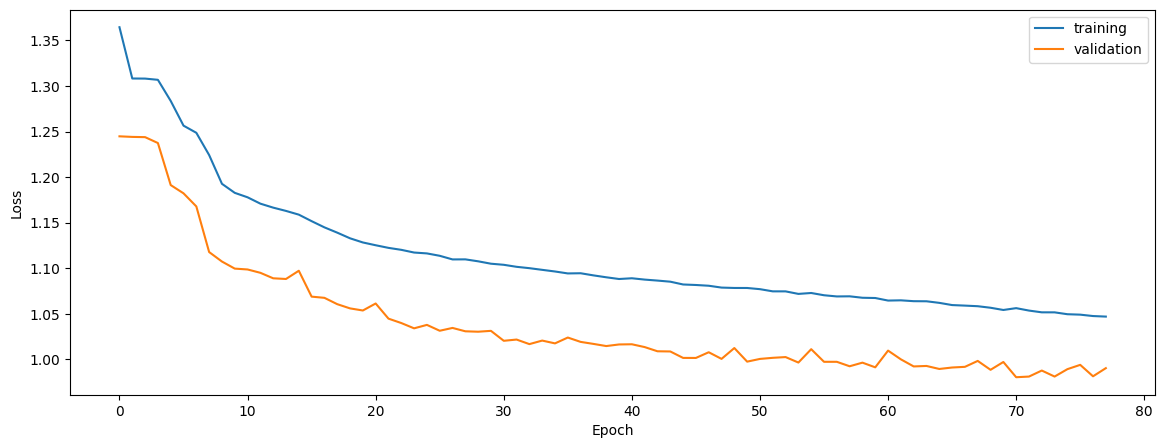

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6370416001216822
0.6661467297762479
0.664488896644998


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.6370416001216822
0.6661467297762479
0.664488896644998


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6380713676649182
0.6655297612498625
0.6680879287473943


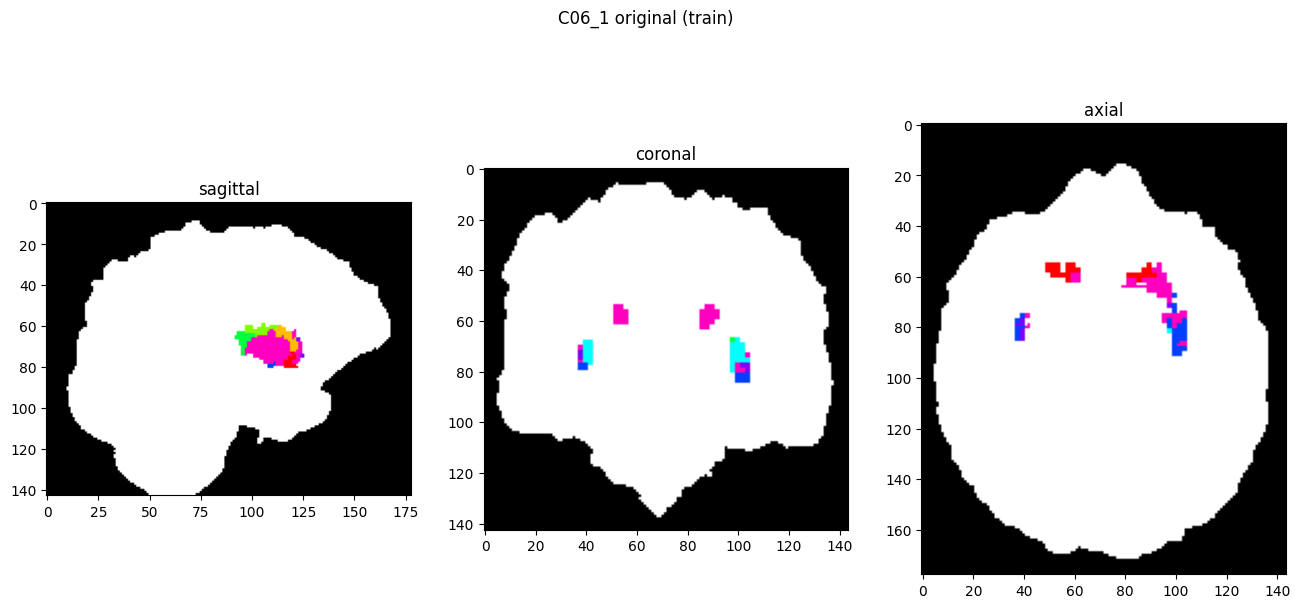

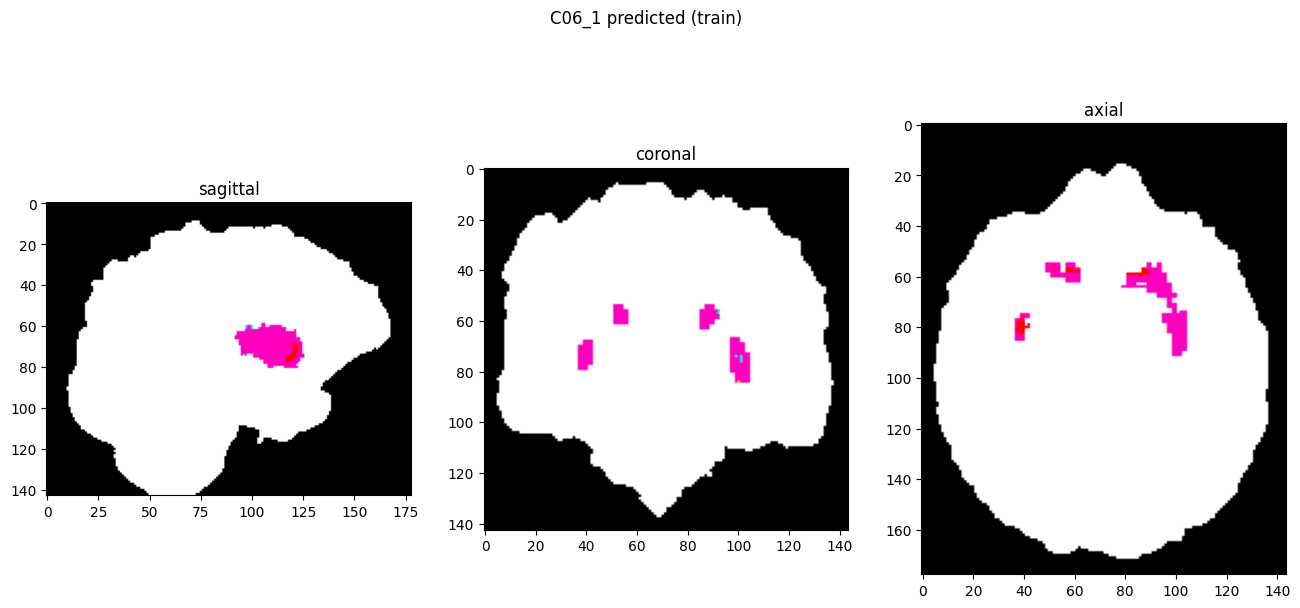

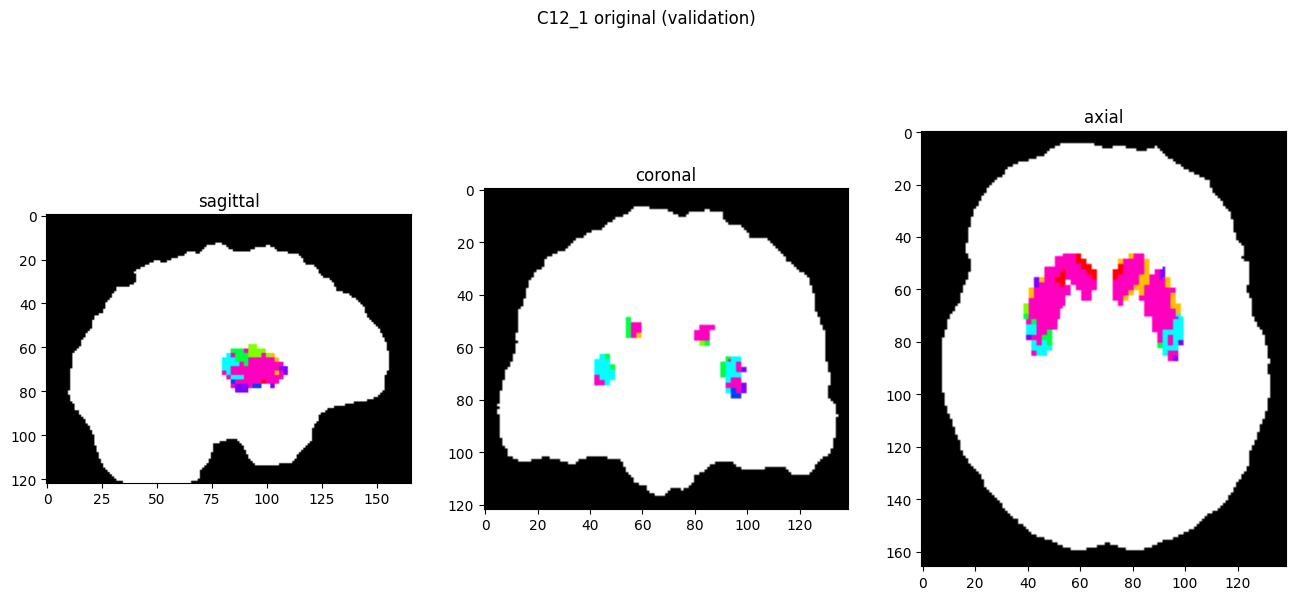

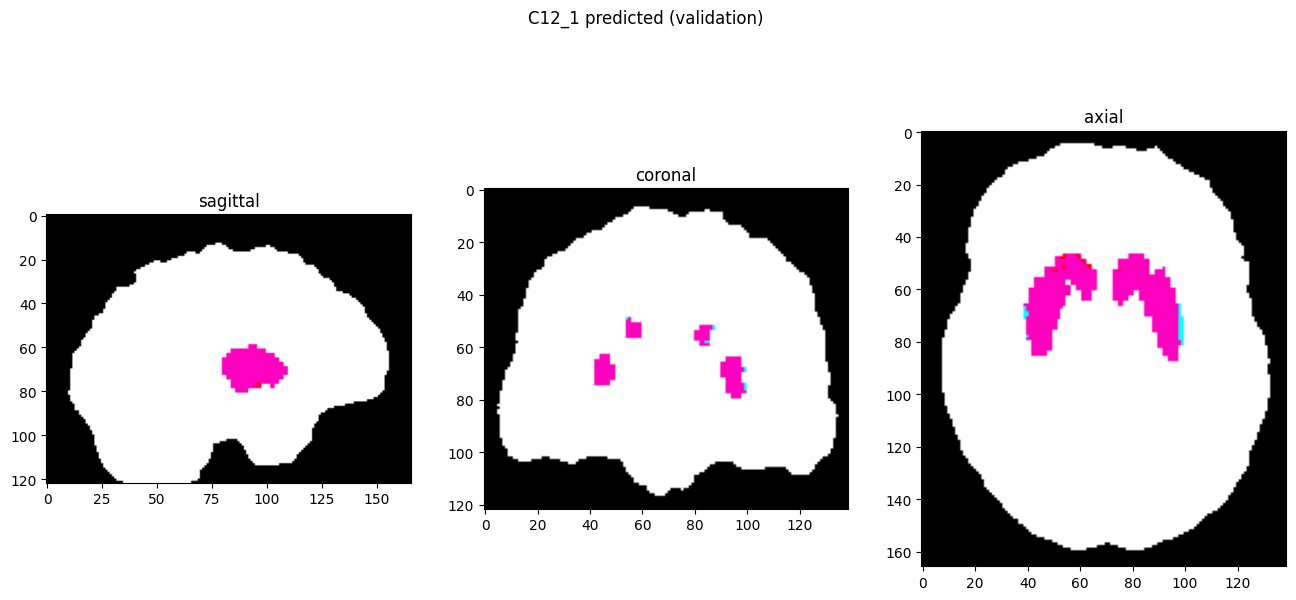

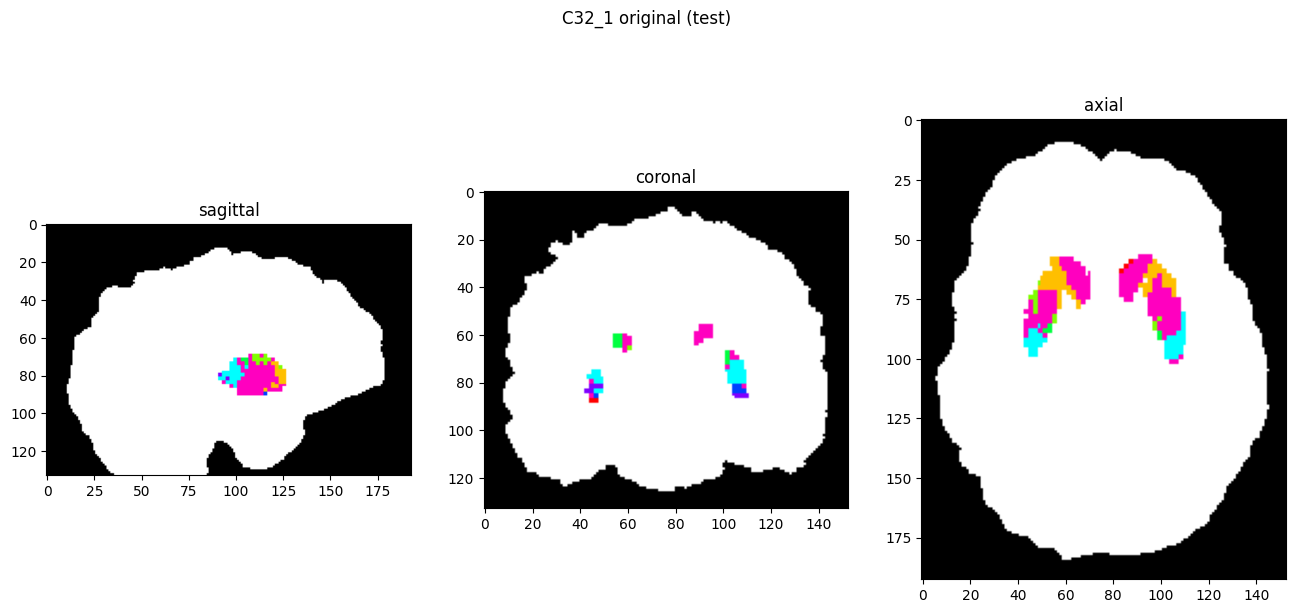

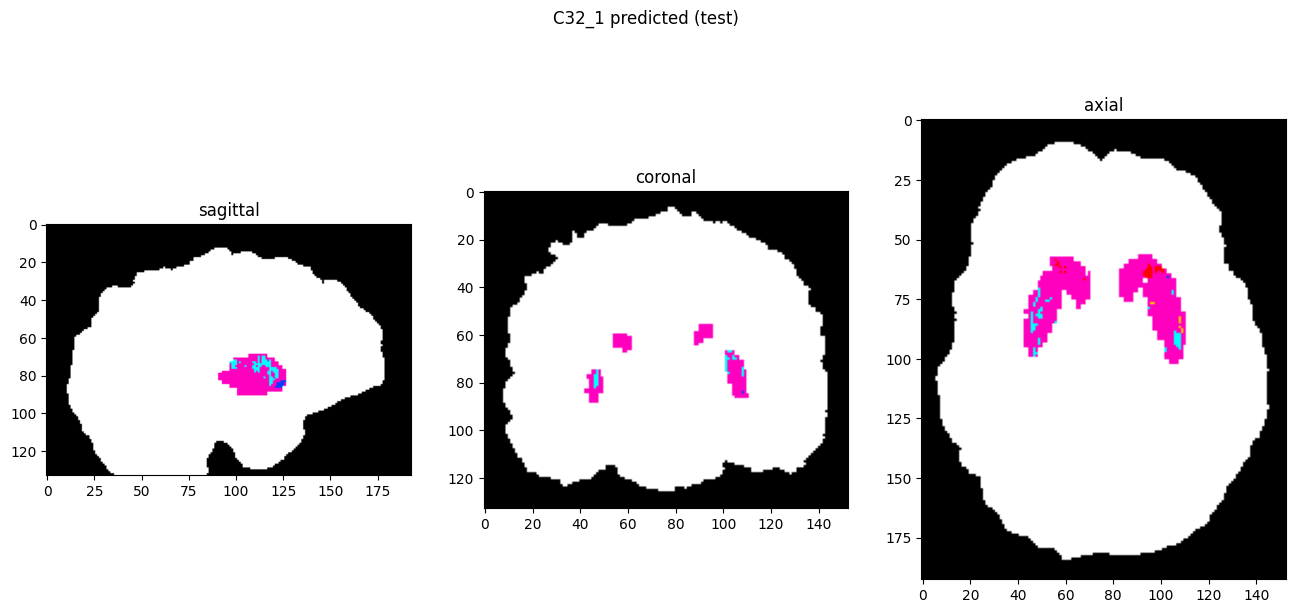

In [10]:
showResults(model, gen, threshold=0)